In [1]:
import os
import sys
import numpy as np
import itertools
import matplotlib.pyplot as plt
from math import pi
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
from orbithunter import *
import inspect
import orbithunter.ks as ks
import h5py
import time
import orbithunter.persistent_homology as ohgudhi
# from orbithunter.persistent_homology import gudhi_distance_from_persistence
from orbithunter.persistent_homology import gudhi_distance_from_persistence, orbit_persistence

# Covering space-time with fundamental orbits.

This notebook produces statistics on the shadowing and covering of space-time by fundamental orbits.
The steps are as follows

    1. Produce a set of fundamental orbits whose combinations are believed to span all possible patterns
    2. Produce a (large) set of windows from trajectories
    3. Calculate the shadowing/covering metric between each window and each fundamental orbit (and group orbits)
    4. Using these distributions, determine a good absolute threshold for the computation of the various coverings.
    5. With each fundamental orbit and its group orbit (if statistics are the same, which they should be, approximately)
       compute the fraction of the large spacetime simulations that each group orbit covers. This can be done
       via either 
    
    
With results from ```continuation.ipynb``` and ```shadowing.ipynb``` we can begin the actual covering portion.

# Determining the sampling of families, group orbits from minimal overlapping sets.

As indicated by its name, ```mask_type=='family'``` is mainly designed for families, i.e. similar orbits of identical size expected to overlap. The reason being that 

Even in the context of the "family" method for calculating covering, if the number of group orbit members for each family member in the covering is large, the computations for a single family on a single domain can take a *very* long time; and this is when . Therefore, it behooves us to determine a subset of group orbit members which provide the most efficient covering, in terms of computational time per area. The idea here being that more group orbit members likely only contribute to overlaps. 

So, the two main steps are: 

    1. Determine efficient number of members per family, as determined by a area proportion per # members plot
    2. Determine efficient number of group members per family, as determined by a area proportion per # group members plot

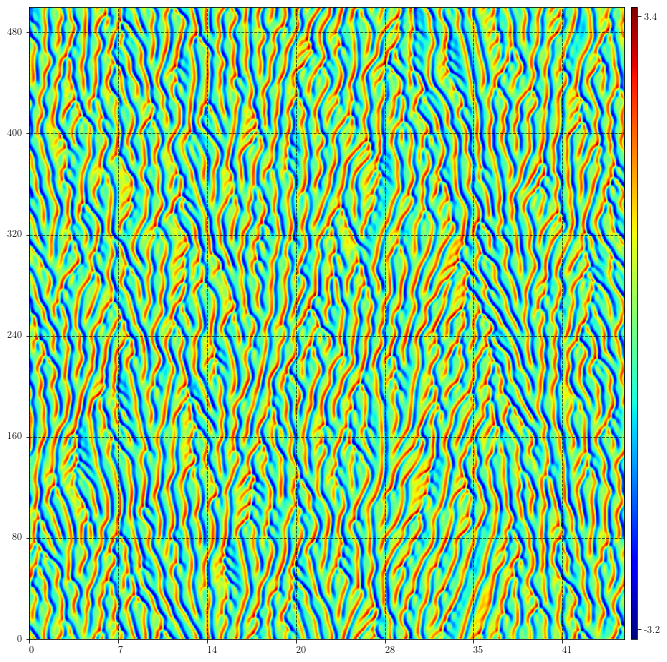

In [2]:
# covering = [x.transform(to='field') for family in read_h5('cover.h5') for x in family]
covering = [x.transform(to='field') for x in read_h5('minimal_cover.h5')]
# Reusing older data but current discretization strategy is to use dx = 0.5 and then choose dt to make orbit state square.
base = read_h5('large_patches.h5', '/1').resize(832, 832)
base.plot()

score_type = 'persistence'
scoring_function = gudhi_distance_from_persistence
persistence_function = orbit_persistence

Import that statistics for the four covering orbits (and their group orbits).

In [3]:
strictness = 0
critical_values = []
with h5py.File('critical_values.h5', 'r') as file:
    for x in file:
        arr = file[x][...]
        critical_values.append(arr)

covering_critical_values = []
for x in critical_values[:-1]:
    # [1,0] is 1 for fundamental domain+amplitude difference, 0 for strictest
    covering_critical_values.append(x[1, strictness])

covering_critical_values.append(critical_values[-1][0, strictness])
covering_critical_values = tuple(covering_critical_values)

In [4]:
covering_critical_persistence_values = []
for x in critical_values[:-1]:
    # [-1,0] is -1 for fundamental domain+persistence, 0 for strictest
    covering_critical_persistence_values.append(x[-1, strictness])

covering_critical_persistence_values.append(critical_values[-1][-2, strictness])
covering_critical_persistence_values = tuple(covering_critical_persistence_values)

In [5]:
# for i in range(len(covering)-1):
#     covering[i] = covering[i].to_fundamental_domain()

In [6]:
covering = tuple(covering)
covering_critical_values

(42.838655013094275, 43.045264545457705, 40.9936067600612, 39.1490960710845)

In [7]:
covering_critical_persistence_values = []
for x in critical_values[:-1]:
    # [-1,0] is -1 for fundamental domain+persistence, 0 for strictest
    covering_critical_persistence_values.append(x[-1, 0])

covering_critical_persistence_values.append(critical_values[-1][-2,0])
covering_critical_persistence_values = tuple(covering_critical_persistence_values)

In [11]:
# # base = read_h5('small_patches.h5', '0')
# # covering = [x.transform(to='field') for family in read_h5('cover.h5') for x in family]
# covering = [x.transform(to='field') for x in read_h5('minimal_cover.h5')]
# covering = tuple(covering)
# covering_mask_prime_replacement_mask = list(covering_mask_prime_replacement.values())[0]
# for masks in list(covering_mask_prime_replacement.values())[1:]:
#     covering_mask_prime_replacement_mask = np.logical_or(covering_mask_prime_replacement_mask, masks)

# orbit_mask = scanning_mask(covering_mask_prime_replacement_mask, base, covering[0], strides=(8,8))

# _ = plt.figure(figsize=(12,12))
# _ = plt.imshow(orbit_mask.astype(int))
# _ = plt.colorbar()

These are the amplitude differences.

In [8]:
def score_array_shape(base_orbit, window_orbit, **kwargs):
    strides = kwargs.get('strides', tuple([1]*len(base_orbit.shapes()[0])))
    score_type = kwargs.get('score_type', 'pointwise')
    # Easiest way I've found to account for periodicity is to pad with wrapped values
    window = window_orbit.state
    base = base_orbit.state

    # To get the padding/wrap number, need to see how much the windows extend "beyond" the base orbit. This can be
    # computed using the placement of the last pivot and the window dimensions. This is only relevant for periodic
    # dimensions in the base orbit. Not specifying min_persistence makes memory requirements very large.

    # The bases orbit periodicity has to do with scoring and whether or not to wrap windows around.
    base_orbit_periodicity = kwargs.get('base_orbit_periodicity', tuple(len(window.shape)*[False]))

    # the periodic_dimensions key here determines the periodic dimensions in the gudhi.PeriodicCubicalComplex
    gudhikwargs = kwargs.get('gudhi_kwargs', {'periodic_dimensions': tuple(len(window.shape)*[False]),
                                              'min_persistence': 0.01})
    dimension_iterator = zip(base.shape, strides, window.shape, base_orbit_periodicity)
    score_array_shape = []
    pad_shape = []
    for base_extent, stride_extent, window_extent, periodic in dimension_iterator:
        # Need to determine the score array and the padding amount, if periodic in that dimension.
        # First pivot position is always at (0, 0), opposite corner is (base_extent-1, base_extent-1)
        # This is really the index of the last pivot along current dimension.
        if periodic:
            num_pivots = ((base_extent-1) // stride_extent) + 1
            spill_over = (window_extent + stride_extent * (num_pivots-1)) - base_extent
            # All pivot points (separated by stride_extent) are admissible with respect to periodic dimensions.
            score_array_shape.append(num_pivots)
            # -1 is a correction for starting at 0 indexing.
            pad_shape.append(spill_over)
        else:
            # If we need padding then the pivot position does not work for aperiodic dimensions. If window extent
            # is large compared to stride then multiple pivots could be out of bounds. Need to reel back until we find
            # one that is not.
            # Extra 1 because iterator provides the index not the number of pivots.
            num_pivots = 1 + (base_extent - window_extent) // stride_extent
            score_array_shape.append(num_pivots)
            pad_shape.append(0)

    # First create an array to store metric values; 1/stride is the sampling fraction, evenly spaced.
    # Want to create the number of pivots based on original array, but to handle "overflow", the wrapped array
    # is used for calculations
    return score_array_shape

In [ ]:
def score_array_shape(base_orbit, window_orbit, **kwargs):
    strides = kwargs.get('strides', tuple([1]*len(base_orbit.shapes()[0])))
    score_type = kwargs.get('score_type', 'pointwise')
    # Easiest way I've found to account for periodicity is to pad with wrapped values
    window = window_orbit.state
    base = base_orbit.state

    strides = kwargs.get('strides', tuple([1]*len(base_orbit.shapes()[0])))
    score_type = kwargs.get('score_type', 'pointwise')
    verbose = kwargs.get('verbose', False)
    pivots = kwargs.get('pivots', ())
    mask = kwargs.get('mask', None)
    # Caching doesn't really make sense for pointwise calculations but included here anyway.
    cache = kwargs.get('cache', {})
    caching = kwargs.get('caching', False)
    # Easiest way I've found to account for periodicity is to pad with wrapped values
    window = window_orbit.state
    base = base_orbit.state

    for w_dim, b_dim in zip(window.shape, base.shape):
        assert w_dim < b_dim, 'Shadowing window discretization is larger than the base orbit. resize first. '

    # To get the padding/wrap number, need to see how much the windows extend "beyond" the base orbit. This can be
    # computed using the placement of the last pivot and the window dimensions. This is only relevant for periodic
    # dimensions in the base orbit. Not specifying min_persistence makes memory requirements very large.

    # The bases orbit periodicity has to do with scoring and whether or not to wrap windows around.
    base_orbit_periodicity = kwargs.get('base_orbit_periodicity', tuple(len(window.shape)*[False]))

    # the periodic_dimensions key here determines the periodic dimensions in the gudhi.PeriodicCubicalComplex
    gudhikwargs = kwargs.get('gudhi_kwargs', {'periodic_dimensions': tuple(len(window.shape)*[False]),
                                              'min_persistence': 0.01})
    dimension_iterator = zip(base.shape, strides, window.shape, base_orbit_periodicity)
    score_array_shape = []
    pad_shape = []
    for base_extent, stride_extent, window_extent, periodic in dimension_iterator:
        # Need to determine the score array and the padding amount, if periodic in that dimension.
        # First pivot position is always at (0, 0), opposite corner is (base_extent-1, base_extent-1)
        # This is really the index of the last pivot along current dimension.
        if periodic:
            num_pivots = ((base_extent-1) // stride_extent) + 1
            spill_over = (window_extent + stride_extent * (num_pivots-1)) - base_extent
            # All pivot points (separated by stride_extent) are admissible with respect to periodic dimensions.
            score_array_shape.append(num_pivots)
            # -1 is a correction for starting at 0 indexing.
            pad_shape.append(spill_over)
        else:
            # If we need padding then the pivot position does not work for aperiodic dimensions. If window extent
            # is large compared to stride then multiple pivots could be out of bounds. Need to reel back until we find
            # one that is not.
            # Extra 1 because iterator provides the index not the number of pivots.
            num_pivots = 1 + (base_extent - window_extent) // stride_extent
            score_array_shape.append(num_pivots)
            pad_shape.append(0)
            
    return score_array_shape, pad_shape

In [10]:
# strides=( 1)
# sashape  = score_array_shape(base, covering[0], base_orbit_periodicity=(False, True), strides=strides)
# with h5py.File('large_patch_persistence.h5', 'r') as file:
#     base_persistence_load = []
#     for j in range(0, sashape[1]):
#         for i in range(0, sashape[0]):
#             index = strides[0]*i + strides[1]*j
#             intv = file[str(index)]['intervals'][...]
#             b = file[str(index)]['betti'][...]
#             base_persistence_load.append(list(zip(b, intv)))
# cache = {(32, 32): base_persistence_load}

# Preliminary testing

As a preliminary trial, run the covering routine with only a small set of covering orbits, not accounting for their
symmetry group orbits. This will give an idea as to whether it will be possible to cover the space. Each fundamental orbit has a discretization of (32,32) even though they do not have the same dimensions; this has to do with performance for the persistent homology calculations. 

With these orbits, scan over the entirety of the base orbit (large trajectory segment) and evaluate the scoring function (amplitude difference) between the window orbit and the subdomain of the base orbit. 

This calculation is shown both "with replacement" and "without replacement". No replacement means that once a detection has been made at a site, it will be skipped over for future orbits in the covering. This is a cumulative process which reduces the numbers of computations for each successive orbit. The motivation being that a region of space-time only shadows a single orbit at a time, by definition. 

To distinguish between overlaps and different orbits in the cover, the ```mask_type='prime'``` keyword argument is provided.
What this does is assigns a prime number (simply in order) to each orbit in the provided cover. Then, instead of producing True (1) for each site testing positive for shadowing, the logarithm of the corresponding prime number is provided. This is
motivated by the prime, the logarithmic sum is used instead of the product of primes for overflow reasons. Therefore, each
site can be factored into a product of primes of multiplicity 1, hence, we can tell which orbits are shadowing which regions
of spacetime. 

The ideal cover is one wherein the covering orbits do not overlap considerably. Otherwise the proportion of the area covered
by each orbit isn't well defined. This may require discarding the points of overlap in the statistics calculations. 

# Key pieces of evidence to collect

The idea here is that if using many different family members or group orbit members is important, then there will not be much overlap between the different covers; each member provides unique detections. The best case scenario is that the covers mostly  overlap, as this means that fewer representatives are required. Clearly, if the covers perfectly overlap then only a single representative is necessary.

To determine this, find the covers for every member of the large defect's family (224 orbits) and a subsample of the group orbit (not exhaustive due to similarities and simply being too many) 

If in either 

# Amplitude difference metric.

The preliminary testing will occur will respect to the amplitude difference metric, with a single base orbit, as it is faster unless using cached persistences.

With replacement

In [31]:
t0=time.time_ns()/10**9
preliminary_cover_no_replacement = cover(base, covering_critical_values, covering,
                            score_type='pointwise',
                            replacement=False,
                            base_orbit_periodicity=(False, True),
                            strides=(1, 1),
                            verbose=True)
t1=time.time_ns()/10**9
print(t1-t0)

#-----------#-----------#-----------#-----------266.741632938385


In [ ]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(preliminary_cover_no_replacement)
_ = plt.colorbar()

In [ ]:
t0=time.time_ns()/10**9
covering_mask_prime_replacement = cover(base, covering_critical_values, covering,
                            score_type='pointwise',
                            replacement=True,
                            base_orbit_periodicity=(False, True),
                            strides=(1, 1),
                            verbose=True)
t1=time.time_ns()/10**9
print(t1-t0)
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(covering_mask_prime_replacement)
_ = plt.colorbar()

Without replacement; there are not enough detections to gain any performance; in fact, keeping
track of the positions and checking seems to decrease performance.

266.79955315589905


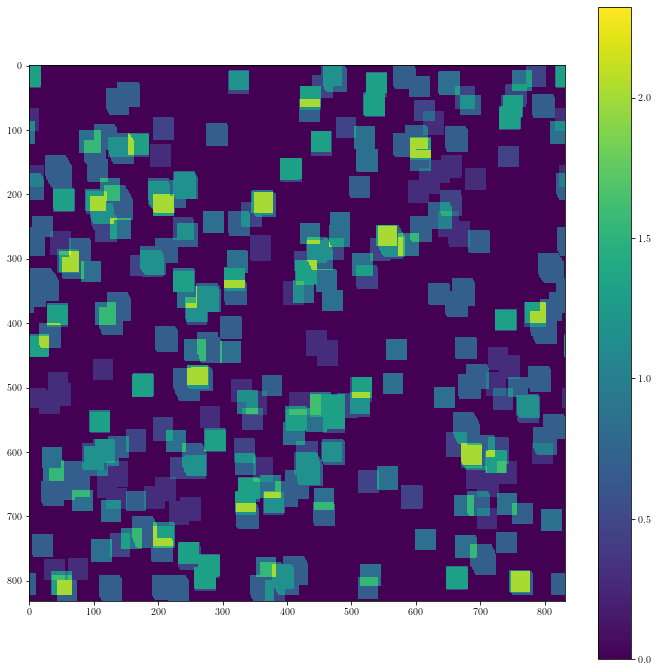

In [55]:
t0=time.time_ns()/10**9
covering_mask_prime = cover(base, covering_critical_values, covering,
                            score_type='pointwise',
                            replacement=False,
                            base_orbit_periodicity=(False, True),
                            strides=(1,1),
                            verbose=False)
t1=time.time_ns()/10**9
print(t1-t0)
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(covering_mask_prime)
_ = plt.colorbar()

In [ ]:
score_type = 'persistence'
scoring_function = gudhi_distance_from_persistence
persistence_function = orbit_persistence
t0p=time.time_ns()/10**9
covering_mask_persistence_prime = cover(base, covering_critical_persistence_values, [x.abs() for x in covering],
                                        replacement=False,
                                        score_type=score_type,
                                         base_orbit_periodicity=(False, True),
                                       scoring_function=scoring_function,
                                       persistence_function=persistence_function,
                                        cache=cache,
                                        strides=strides,
                                        verbose=True
                                       )
t1p=time.time_ns()/10**9

_ = plt.figure(figsize=(12,12))
_ = plt.imshow(covering_mask_persistence_prime)
_ = plt.colorbar()

## Overlap between subsampling of a single family. 

Calculate the covers with respect to the 224 different orbits in the large defect family; this takes approximately 4 hours and so the covers are saved for later use.

In [32]:
# to make it more manageable for a preliminary test, only take 20 or so family members
large_defect_family = tuple([x.to_fundamental_domain() for x in read_h5('large_cover.h5', 'large_defect/')])
large_defect_family_critical_values = tuple([covering_critical_values[2]]*len(large_defect_family))

t0=time.time_ns()/10**9
large_defect_covering = cover(base, large_defect_family_critical_values, large_defect_family,
                            score_type='pointwise',
                            replacement=True,
                            base_orbit_periodicity=(False, True),
                            strides=(1,1),
                            verbose=True)
t1=time.time_ns()/10**9
print(t1-t0)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

65

In [58]:

OrbitKS(state=v.astype(int), parameters=base.parameters, basis='field').to_h5('large_defect_family_covering.h5', verbose=True)

Writing dataset "/0" to file large_defect_family_covering.h5
Writing dataset "/1" to file large_defect_family_covering.h5
Writing dataset "/2" to file large_defect_family_covering.h5
Writing dataset "/3" to file large_defect_family_covering.h5
Writing dataset "/4" to file large_defect_family_covering.h5
Writing dataset "/5" to file large_defect_family_covering.h5
Writing dataset "/6" to file large_defect_family_covering.h5
Writing dataset "/7" to file large_defect_family_covering.h5
Writing dataset "/8" to file large_defect_family_covering.h5
Writing dataset "/9" to file large_defect_family_covering.h5
Writing dataset "/10" to file large_defect_family_covering.h5
Writing dataset "/11" to file large_defect_family_covering.h5
Writing dataset "/12" to file large_defect_family_covering.h5
Writing dataset "/13" to file large_defect_family_covering.h5
Writing dataset "/14" to file large_defect_family_covering.h5
Writing dataset "/15" to file large_defect_family_covering.h5
Writing dataset "/

Writing dataset "/132" to file large_defect_family_covering.h5
Writing dataset "/133" to file large_defect_family_covering.h5
Writing dataset "/134" to file large_defect_family_covering.h5
Writing dataset "/135" to file large_defect_family_covering.h5
Writing dataset "/136" to file large_defect_family_covering.h5
Writing dataset "/137" to file large_defect_family_covering.h5
Writing dataset "/138" to file large_defect_family_covering.h5
Writing dataset "/139" to file large_defect_family_covering.h5
Writing dataset "/140" to file large_defect_family_covering.h5
Writing dataset "/141" to file large_defect_family_covering.h5
Writing dataset "/142" to file large_defect_family_covering.h5
Writing dataset "/143" to file large_defect_family_covering.h5
Writing dataset "/144" to file large_defect_family_covering.h5
Writing dataset "/145" to file large_defect_family_covering.h5
Writing dataset "/146" to file large_defect_family_covering.h5
Writing dataset "/147" to file large_defect_family_cove

We are hoping that each cover's contribution overlaps with another, such that a minimal set can be selected. Visualize this by summation of each of the boolean masks and plotting as a density plot. Non-zero values indicate the number of covers which yielded detections at a site.

In [398]:
large_defect_family[68].t

13.9806297752476

In [231]:
large_defect_covering[0]
=  scanning_mask(large_defect_covering[108] , base, large_defect_family[0], strides=(1,1)).astype(int)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

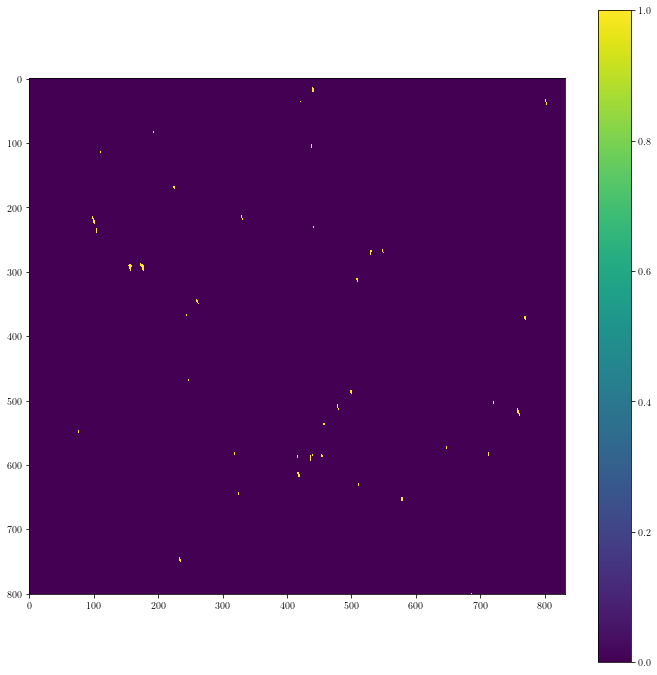

In [293]:
for k,v in double_defect_covering.items():
    if k == 0:
        lddetections2 = v
    else:
        lddetections2 = np.logical_or(lddetections2, v)
        
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(lddetections2.astype(int))
_ = plt.colorbar()

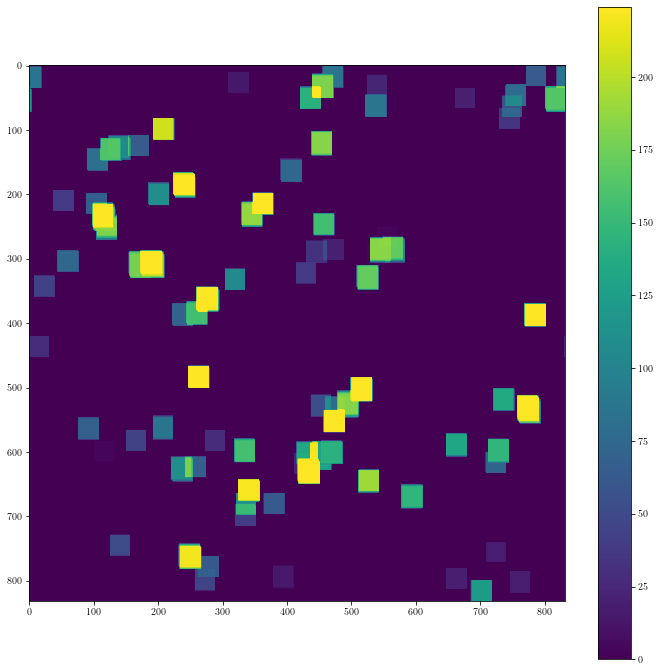

In [375]:
for k,v in large_defect_covering.items():
    if k == 0:
        ldcm = scanning_mask(v, base, large_defect_family[0], strides=(1,1)).astype(int)
    else:
        ldcm+= scanning_mask(v, base, large_defect_family[0], strides=(1,1)).astype(int)
        
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(ldcm)
_ = plt.colorbar()

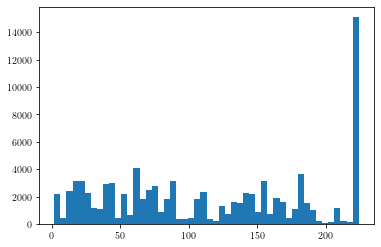

In [89]:
plt.hist(ldcm[ldcm!=0], bins=50)
plt.show()

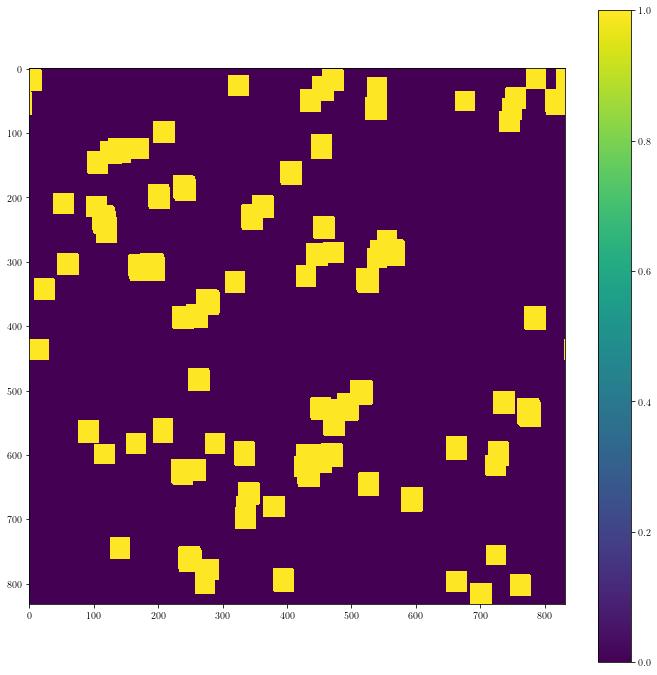

In [114]:
unique_ldcm = ldcm.copy()
unique_ldcm[unique_ldcm>=2] = 1
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(unique_ldcm)
_ = plt.colorbar()

Plot the proportion of the **covered** area by the overlap values. Want to find the smallest value that
captures most of the area covered. 

In [364]:
covered_area = ldcm[ldcm>0].size
# area_proportion_family_cover = covered_area / ldcm.size

In [366]:
covered_points = ldcm[ldcm>0]

In [ ]:
unique_ldcm

In [378]:
unique_ldcm = ldcm.copy()

In [365]:
unique_ldcm = unique_ldcm[unique_ldcm>0]

In [386]:
ldcm.shape

(832, 832)

In [379]:
unique_ldcm[unique_ldcm>3]=0
unique_ldcm = unique_ldcm.astype(bool)

In [382]:
unique_ldcm.sum(), ldcm.astype(bool).sum()

(1721, 90377)

In [387]:
contributions = []
for keys, covers in large_defect_covering.items():
    contributions.append(np.logical_and(covers, lddetections).sum())

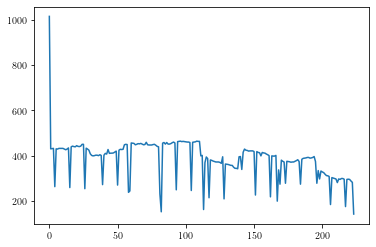

In [389]:
plt.plot(contributions)

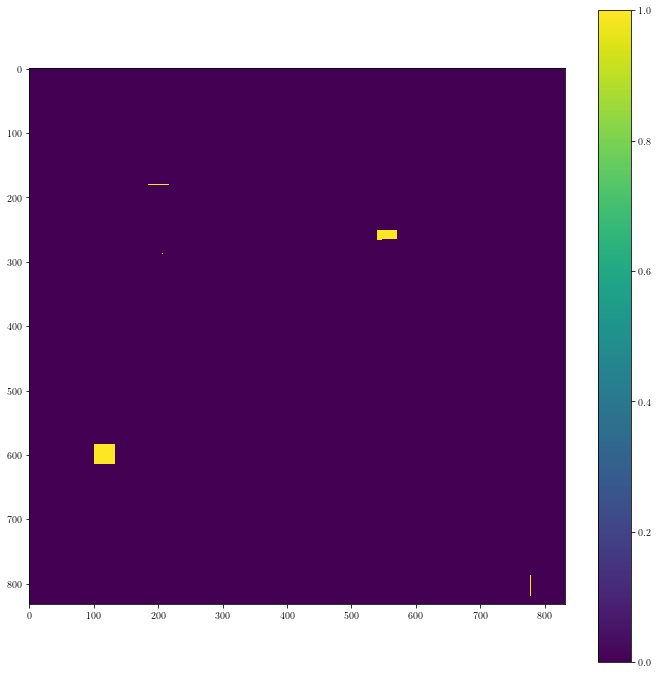

In [383]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow((unique_ldcm).astype(int))
_ = plt.colorbar()

In [123]:
np.unique(unique_ldcm)[::-1]

In [373]:
np.unique(covered_points)

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

In [369]:
area_proportions_per_val = []
for vals in np.unique(covered_points):
    area_proportions_per_val.append(covered_points[covered_points<=vals].size / unique_ldcm.size)

Look at the proportion of the covered area per overlap value. If the cover was NOT overlapping, we would expect that the proportion of area covered by values SMALLER than the number of overlaps would be large. In other words, if there was perfect cover without any overlap, then 100% of the area would be covered by values 1 or less.

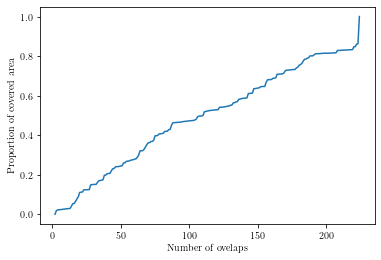

In [371]:
_ = plt.figure()
plt.plot(np.unique(covered_points), area_proportions_per_val)
plt.xlabel('Number of ovelaps')
plt.ylabel('Proportion of covered area')
plt.show()

To interpret this plot, less than 2% of the covered area has less than or equal to 3 overlaps. This means that the vast majority of information is redundant. This allows us to select a small number of representatives with which to cover the space.
Do this simply by returning those which cover the most area.

In [172]:
detections = []
for k,v in large_defect_covering.items():
    detections.append(v.sum())

In [255]:
size_order=np.array([223,222,81,80,79,78,77,76,75,74,73,72,71,70,69,68,67,66,
65,64,63,62,61,60,59,58,57,82,83,84,98,109,108,107,106,105,
104,103,102,101,100,99,97,85,96,95,94,93,92,91,90,89,88,87,
86,56,55,54,13,24,23,22,21,20,19,18,17,16,15,14,12,26,
11,10,9,8,7,6,5,4,3,2,1,25,27,53,41,52,51,50,
49,48,47,46,45,44,43,42,40,28,39,38,37,36,35,34,33,32,
31,30,29,110,111,112,182,193,192,191,190,189,188,187,186,185,184,183,
181,195,180,179,178,177,176,175,174,173,172,171,170,194,196,168,210,221,
220,219,218,217,216,215,214,213,212,211,209,197,208,207,206,205,204,203,
202,201,200,199,198,169,167,113,126,137,136,135,134,133,132,131,130,129,
128,127,125,139,124,123,122,121,120,119,118,117,116,115,114,138,140,166,
154,165,164,163,162,161,160,159,158,157,156,155,153,141,152,151,150,149,
148,147,146,145,144,143,142,0])


In [322]:
large_defect_covering_key_correct = large_defect_covering.copy()

In [325]:
large_defect_covering_key_correct = {size_order[k]:v for k,v in large_defect_covering_key_correct.items()}

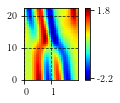

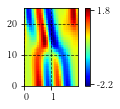

In [332]:
for x in np.array(large_defect_family)[[223, 31]]:
    x.plot()

If these two orbits provide the vast majority of the covering, know that we can take 2 out of 224 family members; a dramatic reduction.

In [278]:
t0=time.time_ns()/10**9
double_defect_covering = cover(base, tuple(2*[large_defect_family_critical_values[223]]), tuple([large_defect_family[223], large_defect_family[31]]),
                                                    score_type='pointwise',
                                                    replacement=True,
                                                    base_orbit_periodicity=(False, True),
                                                    strides=(1,1),
                                                    verbose=True)
t1=time.time_ns()/10**9
print(t1-t0)

#-----------#-----------136.60000109672546


{0: array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [284]:

c223 = scanning_mask(double_defect_covering[0], base, large_defect_family[0], strides=(1,1)).astype(int)
c31 = scanning_mask(double_defect_covering[1], base, large_defect_family[0], strides=(1,1)).astype(int)

In [316]:
double_defect_covering[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [341]:
np.logical_xor(double_defect_covering[0], double_defect_covering[1]).sum()

165

In [345]:
double_defect_covering[0]
orthogonal_sums = []
current_mask = np.logical_or(double_defect_covering[0],double_defect_covering[1])
keys = []
for key, mask in large_defect_covering_key_correct.items():
    if key not in [223, 31]:
        keys.append(key)
        orthogonal_sums.append(np.logical_xor(current_mask, mask).sum())


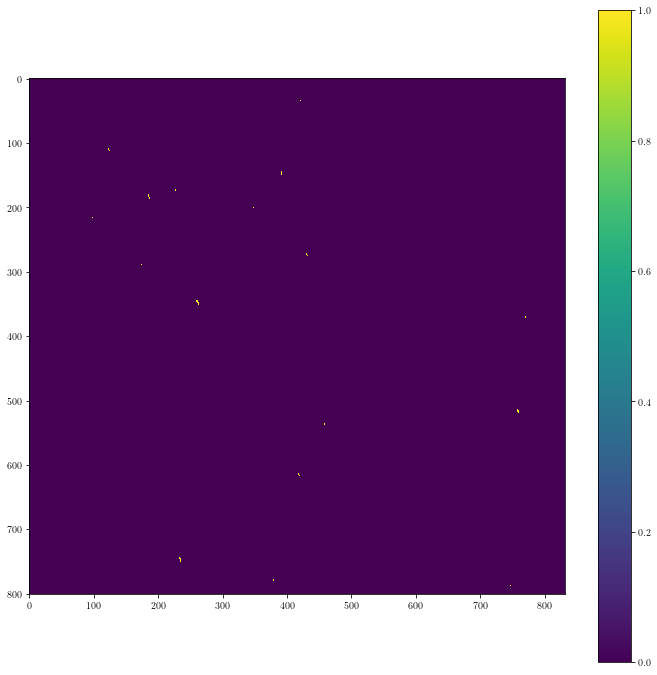

In [394]:
next_mask = large_defect_covering_key_correct[139]
_ = plt.figure(figsize=(12,12))
_ = plt.imshow((large_defect_covering_first_element_only[0]).astype(int))
_ = plt.colorbar()


In [393]:
next_mask = large_defect_covering_key_correct[139]
_ = plt.figure(figsize=(12,12))
_ = plt.imshow((current_mask).astype(int))
_ = plt.colorbar()

_ = plt.figure(figsize=(12,12))
_ = plt.imshow((next_mask).astype(int))
_ = plt.colorbar()

_ = plt.figure(figsize=(12,12))
_ = plt.imshow(np.logical_xor(next_mask, current_mask).astype(int))
_ = plt.colorbar()

AttributeError: 'dict' object has no attribute 'astype'

<Figure size 864x864 with 0 Axes>

In [363]:
np.logical_xor(current_orbit_mask, ldcm.astype(bool)).sum() / ldcm.astype(bool).sum()

0.30307489737433196

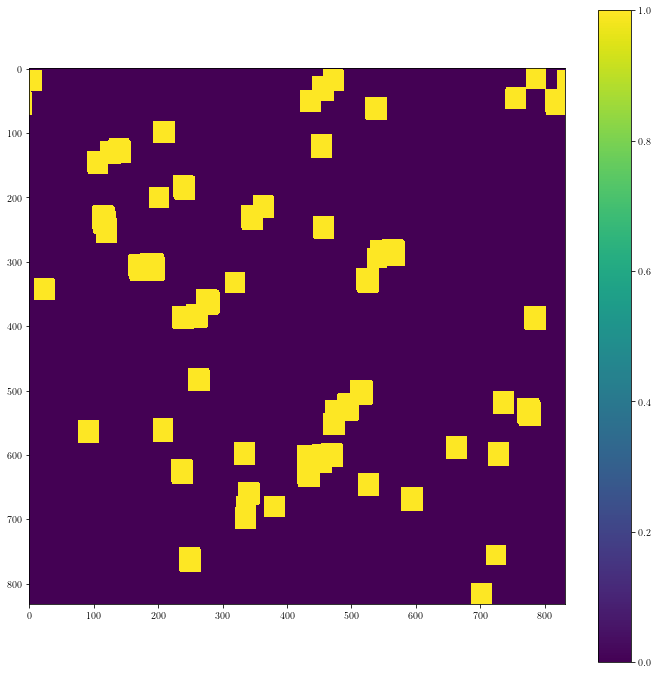

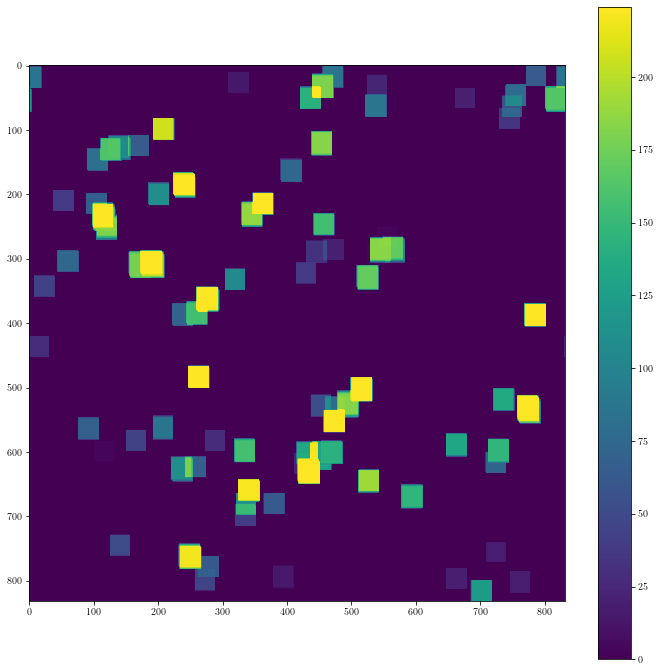

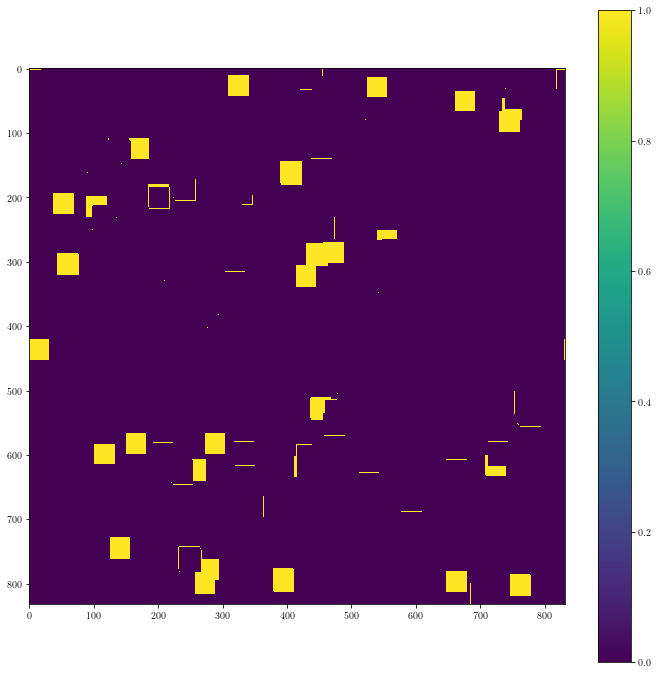

In [358]:
current_orbit_mask = scanning_mask(current_mask, base, large_defect_family[0], strides=(1,1)).astype(int)
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(current_orbit_mask.astype(int))
_ = plt.colorbar()

_ = plt.figure(figsize=(12,12))
_ = plt.imshow((ldcm).astype(int))
_ = plt.colorbar()

_ = plt.figure(figsize=(12,12))
_ = plt.imshow(np.logical_xor(current_orbit_mask, ldcm.astype(bool)).astype(int))
_ = plt.colorbar()

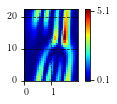

In [310]:
(large_defect_family[223].change_reference_frame(to='comoving')**2).plot()

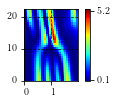

In [304]:
(large_defect_family[223]**2).plot()

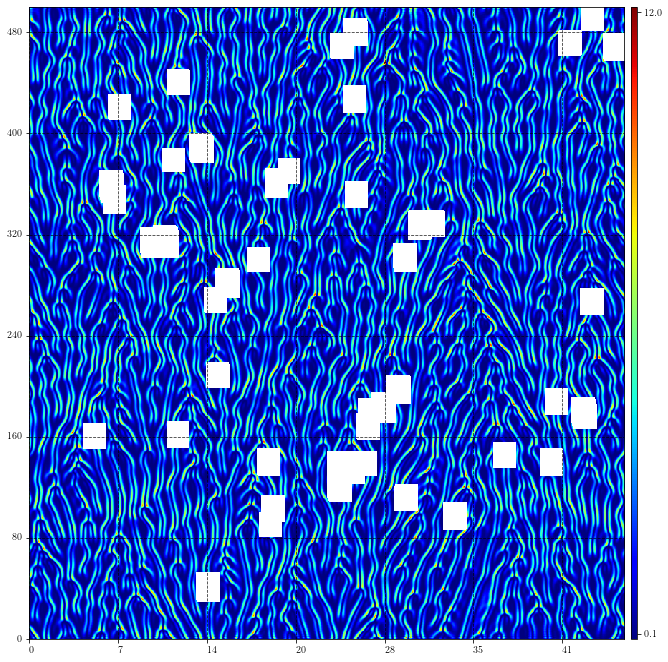

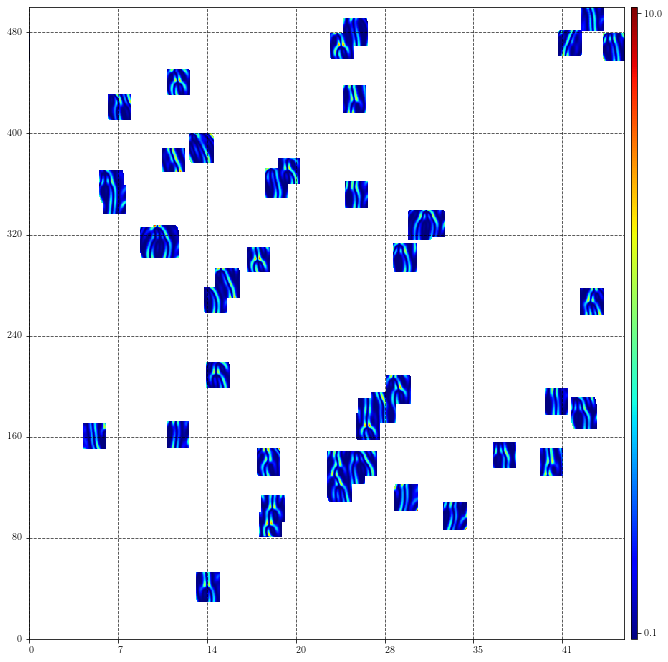

In [300]:
bool_mask = ldc223
bool_mask[bool_mask!=0]=1
base.__class__(state=np.ma.masked_array(base.state**2, mask=bool_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()
base.__class__(state=np.ma.masked_array(base.state**2, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

In [311]:
ldc_subsample = np.logical_or(ldc223, ldc31)
ldmask_subsample = scanning_mask(ldc_subsample, base, large_defect_family[0], strides=(1,1)).astype(int)

To see the number of unique points in the cover, take the logical xor of each mask

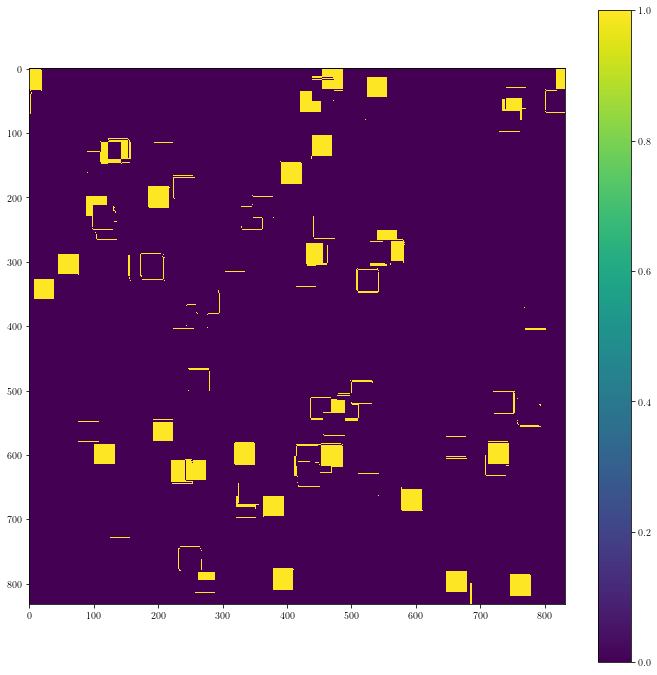

In [77]:
for k,v in large_defect_covering.items():
    if k == 0:
        ldcm_and = scanning_mask(v, base, large_defect_family[0], strides=(1,1))
    else:
        ldcm_and = np.logical_xor(ldcm_and, scanning_mask(v, base, large_defect_family[0], strides=(1,1)))
        
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(ldcm_and.astype(int))
_ = plt.colorbar()

In [ ]:
large_defect_family_critical_persistence_values = tuple([covering_critical_persistence_values[0]]*len(large_defect_family))


t0fp=time.time_ns()/10**9
large_defect_family_covering_persistence = cover(base, large_defect_family_critical_persistence_values,
                                                 [d.abs() for d in large_defect_family],
                                           mask_type='prime',
                                           replacement=True,
                                           score_type=score_type,
                                           base_orbit_periodicity=(False, True),
                                           scoring_function=scoring_function,
                                           persistence_function=persistence_function,
                                           cache=cache,
                                           strides=strides,
                                           verbose=True
                                           )
t1fp=time.time_ns()/10**9

In [9]:
# # to make it more manageable for a preliminary test, only take 20 or so family members
# defect_family = tuple([x.to_fundamental_domain() for x in read_h5('large_cover.h5', 'defect/')[::3]])
# defect_family_critical_values = tuple([covering_critical_values[0]]*len(defect_family))
# defect_family_critical_persistence_values = tuple([covering_critical_persistence_values[0]]*len(defect_family))


# t0fp=time.time_ns()/10**9
# defect_family_covering_persistence = cover(base, defect_family_critical_persistence_values, [d.abs() for d in defect_family],
#                                            mask_type='prime',
#                                            replacement=True,
#                                            score_type=score_type,
#                                            base_orbit_periodicity=(False, True),
#                                            scoring_function=scoring_function,
#                                            persistence_function=persistence_function,
#                                            cache=cache,
#                                            strides=(8,8),
#                                            verbose=True
#                                            )
# t1fp=time.time_ns()/10**9

In [ ]:

# t0fp=time.time_ns()/10**9
# defect_family_covering_persistence = cover(base, defect_family_critical_persistence_values, [d.abs() for d in defect_family],
#                                            mask_type='prime',
#                                            replacement=True,
#                                            score_type=score_type,
#                                            base_orbit_periodicity=(False, True),
#                                            scoring_function=scoring_function,
#                                            persistence_function=persistence_function,
#                                            cache=cache,
#                                            strides=(8,8),
#                                            verbose=True
#                                            )
# t1fp=time.time_ns()/10**9

## Overlap between subsampling of a single group orbit. 

The next component to determine is how much redundancy there is between different members of an orbits' group orbit;
that is, the set of symmetry related fields. To test this, the same uber-strictness is applied to 128 group orbit members
of the large defect. The scanning occurs with respect to the same base orbit as before.

In [33]:
defects = [list(x.group_orbit(fundamental_domain=True,continuous=True, rolls=(12, 12))) for x in covering[:-1]]
wiggle = list(covering[-1].group_orbit(continuous=True, rolls=(12, 12)))
covering_group_orbit = [orbits for families in defects for orbits in families]+wiggle
cvals_group_orbit = [y for x in [9*[cval] for cval in covering_critical_values] for y in x]

In [59]:
large_defect_group_orbit = tuple(covering[2].group_orbit(rolls=(4, 4), fundamental_domain=True))
large_defect_group_orbit_critical_values = tuple([covering_critical_values[2]]*len(large_defect_group_orbit))

t0g=time.time_ns()
group_orbit_covering = cover(base, large_defect_group_orbit_critical_values, large_defect_group_orbit,
                            score_type='pointwise',
                            replacement=True,
                            base_orbit_periodicity=(False, True),
                            strides=(1, 1),
                            verbose=True)
t1g=time.time_ns()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [68]:
((t1g-t0g)/10**9)/3600

2.3892198324166665

In [60]:
for k,v in group_orbit_covering.items():
    OrbitKS(state=v.astype(int), parameters=base.parameters,
            basis='field').to_h5('large_defect_group_orbit_covering.h5', verbose=True)


Writing dataset "/0" to file large_defect_group_orbit_covering.h5
Writing dataset "/1" to file large_defect_group_orbit_covering.h5
Writing dataset "/2" to file large_defect_group_orbit_covering.h5
Writing dataset "/3" to file large_defect_group_orbit_covering.h5
Writing dataset "/4" to file large_defect_group_orbit_covering.h5
Writing dataset "/5" to file large_defect_group_orbit_covering.h5
Writing dataset "/6" to file large_defect_group_orbit_covering.h5
Writing dataset "/7" to file large_defect_group_orbit_covering.h5
Writing dataset "/8" to file large_defect_group_orbit_covering.h5
Writing dataset "/9" to file large_defect_group_orbit_covering.h5
Writing dataset "/10" to file large_defect_group_orbit_covering.h5
Writing dataset "/11" to file large_defect_group_orbit_covering.h5
Writing dataset "/12" to file large_defect_group_orbit_covering.h5
Writing dataset "/13" to file large_defect_group_orbit_covering.h5
Writing dataset "/14" to file large_defect_group_orbit_covering.h5
Writi

Writing dataset "/123" to file large_defect_group_orbit_covering.h5
Writing dataset "/124" to file large_defect_group_orbit_covering.h5
Writing dataset "/125" to file large_defect_group_orbit_covering.h5
Writing dataset "/126" to file large_defect_group_orbit_covering.h5
Writing dataset "/127" to file large_defect_group_orbit_covering.h5


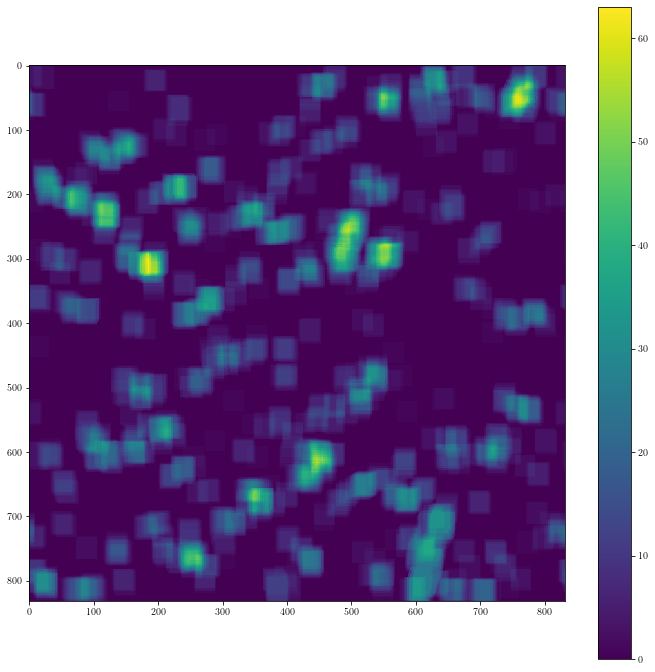

In [65]:
for k,v in group_orbit_covering.items():
    if k == 0:
        ldgocm = scanning_mask(v, base, large_defect_family[0], strides=(1,1)).astype(int)
    else:
        ldgocm+= scanning_mask(v, base, large_defect_family[0], strides=(1,1)).astype(int)
        
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(ldgocm)
_ = plt.colorbar()

In [ ]:
strides=(1, 1)
sashape  = score_array_shape(base, covering[0], base_orbit_periodicity=(False, True), strides=strides)

cache = {}
with h5py.File('large_patch_persistence.h5', 'r') as file:
    for y in file['0/']['(32, 32)']:
        print(y)
        cache[y] = tuple(zip(file['0/(32, 32)'][y]['betti_numbers'], file['0/(32, 32)'][y]['intervals']))

# Covering with group orbit

In [30]:
defects = [list(x.group_orbit(fundamental_domain=True,continuous=True, rolls=(12, 12))) for x in covering[:-1]]
wiggle = list(covering[-1].group_orbit(continuous=True, rolls=(12, 12)))
covering_group_orbit = [orbits for families in defects for orbits in families]+wiggle
cvals_group_orbit = [y for x in [9*[cval] for cval in covering_critical_values] for y in x]

t0g=time.time_ns()
group_orbit_covering = cover(base, cvals_group_orbit, covering_group_orbit,
                            score_type='pointwise',
                            replacement=True,
                            base_orbit_periodicity=(False, True),
                            strides=(1, 1),
                            verbose=True)
t1g=time.time_ns()

#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------#-----------

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


KeyboardInterrupt: 

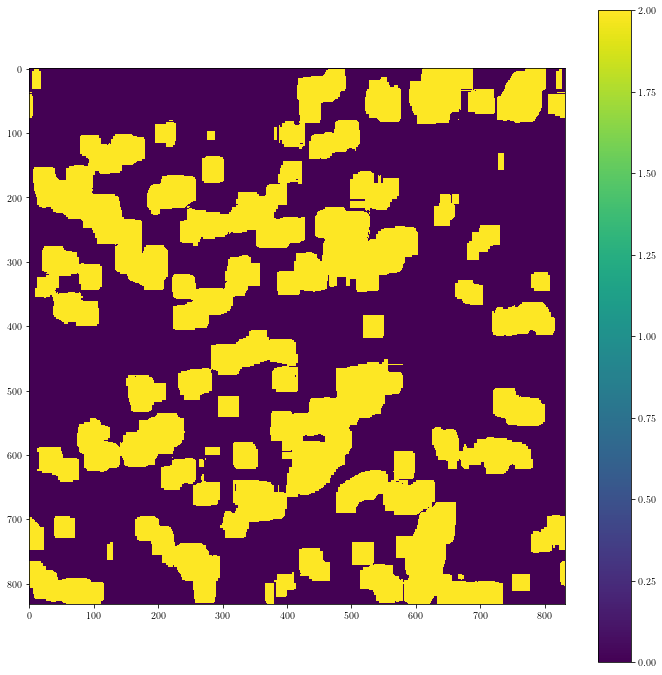

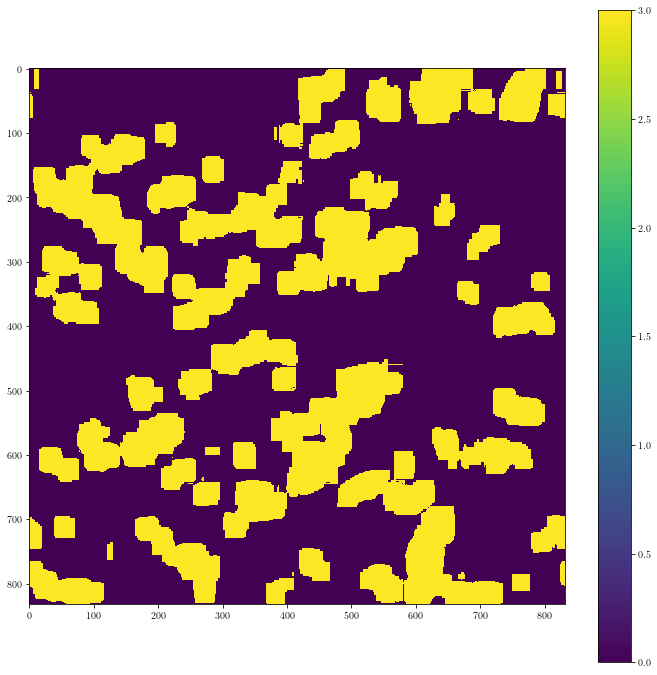

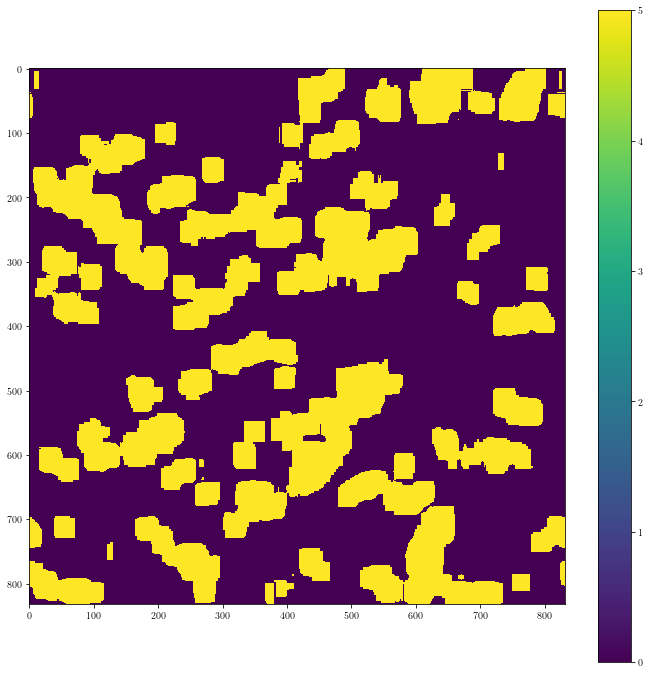

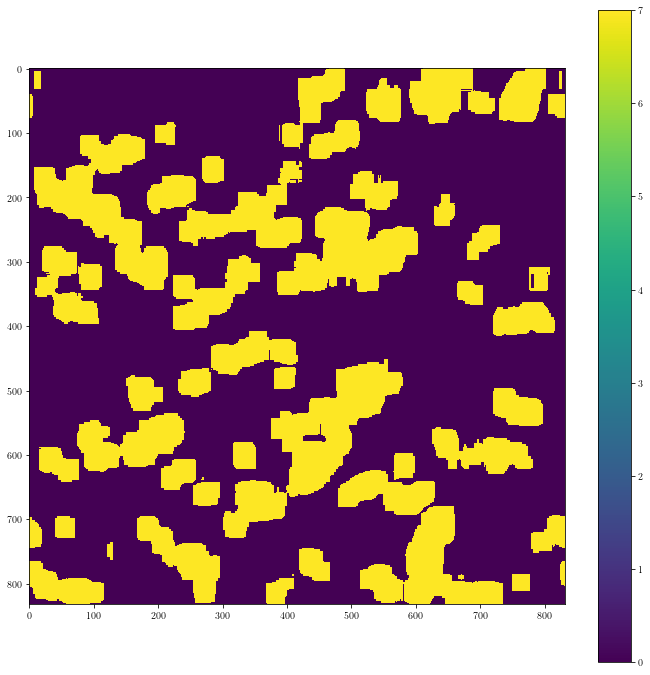

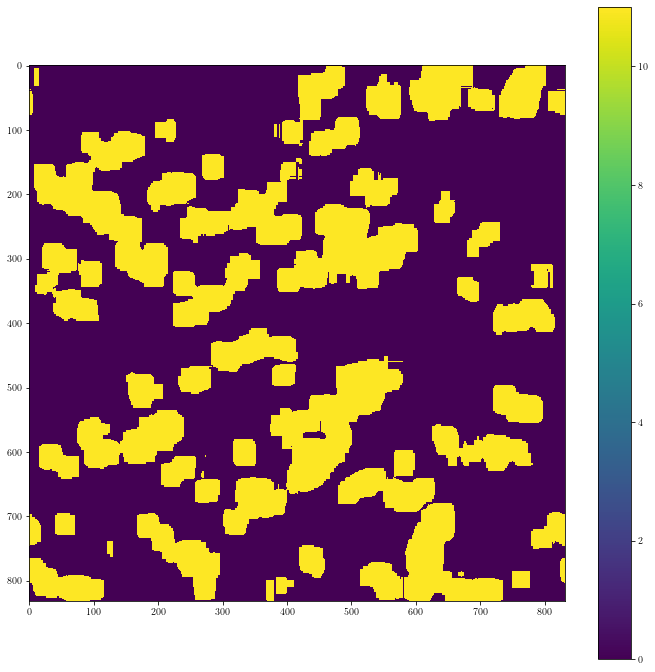

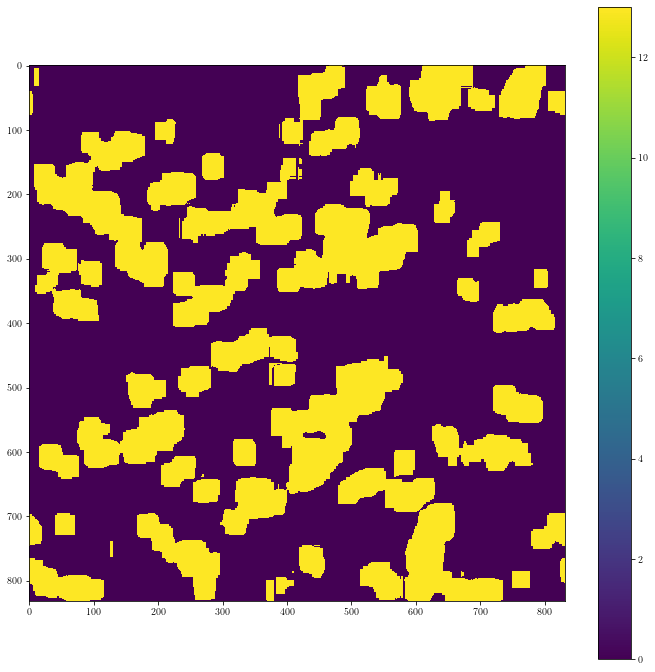

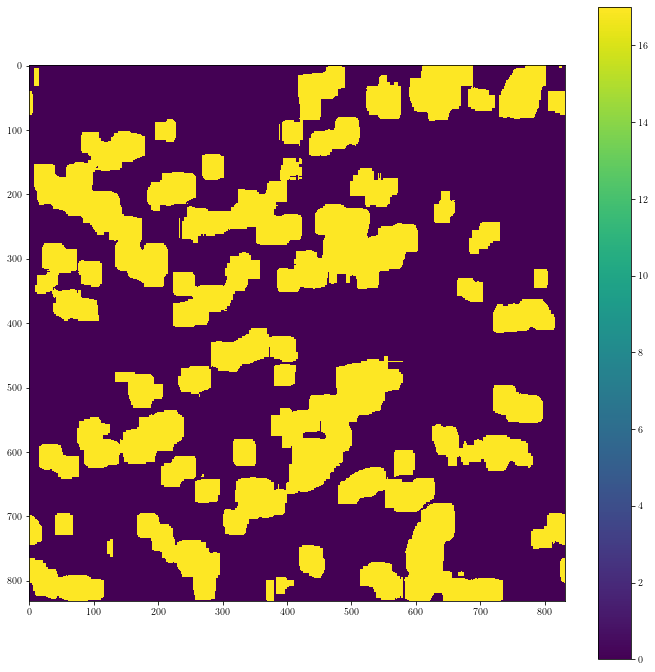

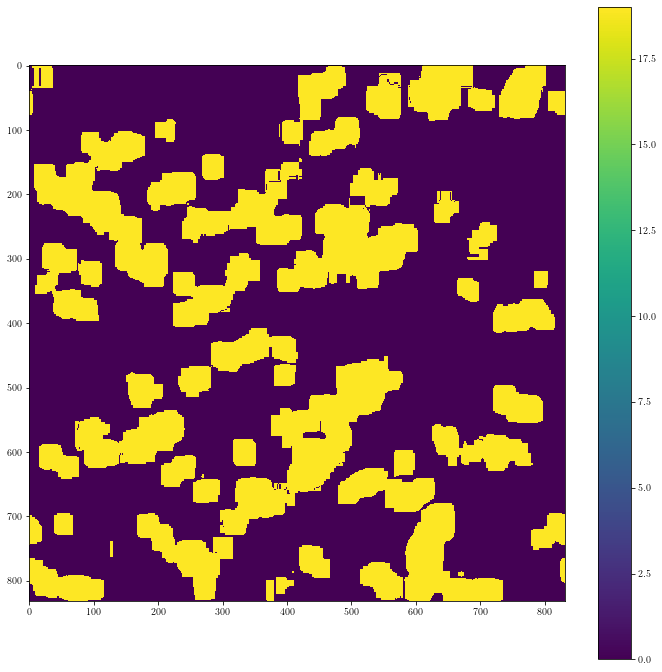

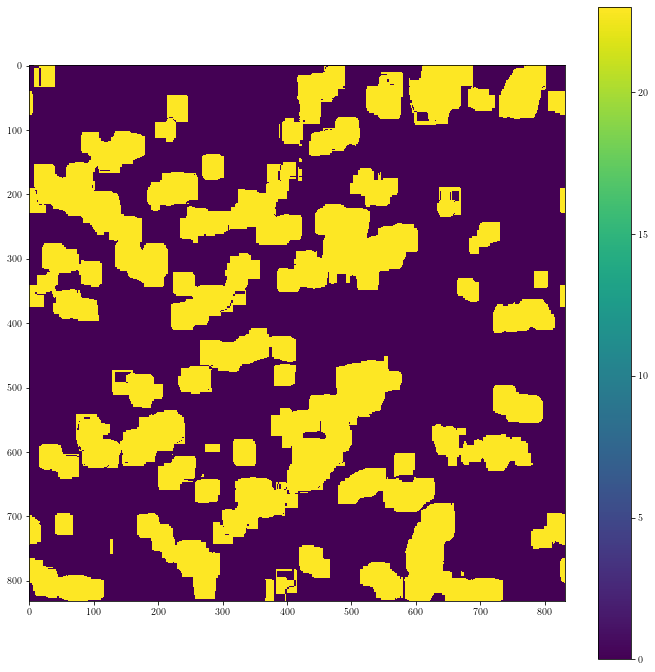

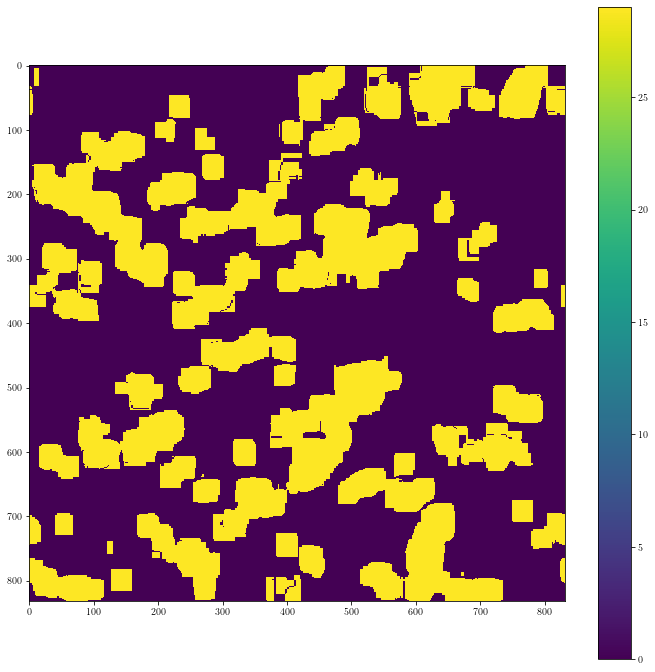

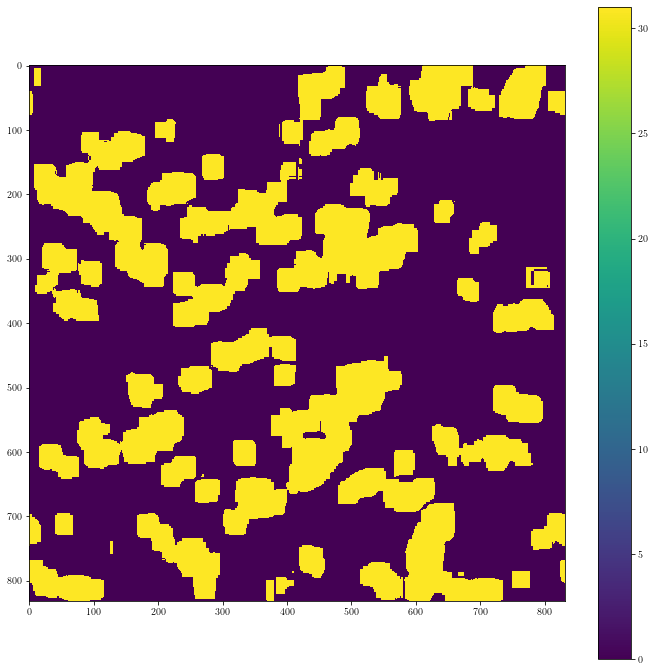

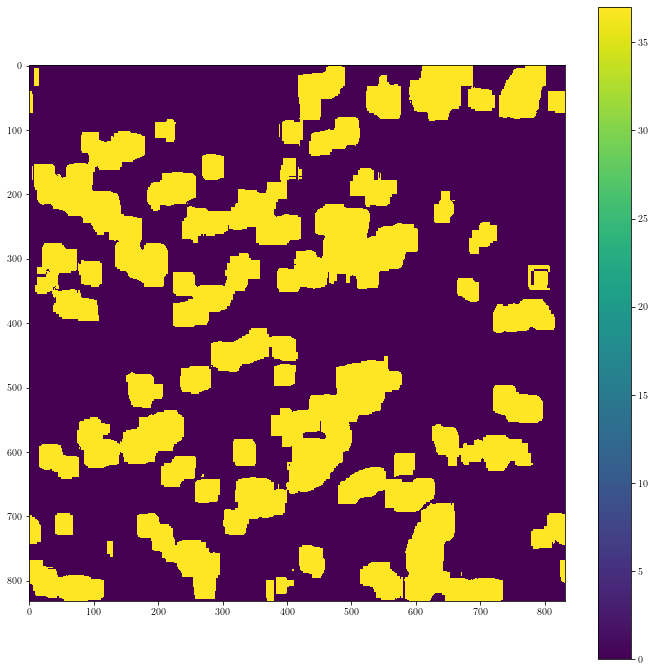

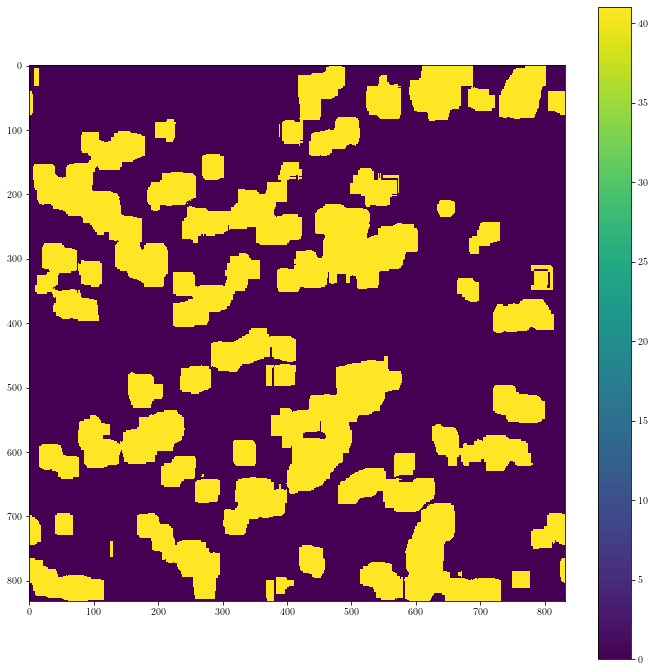

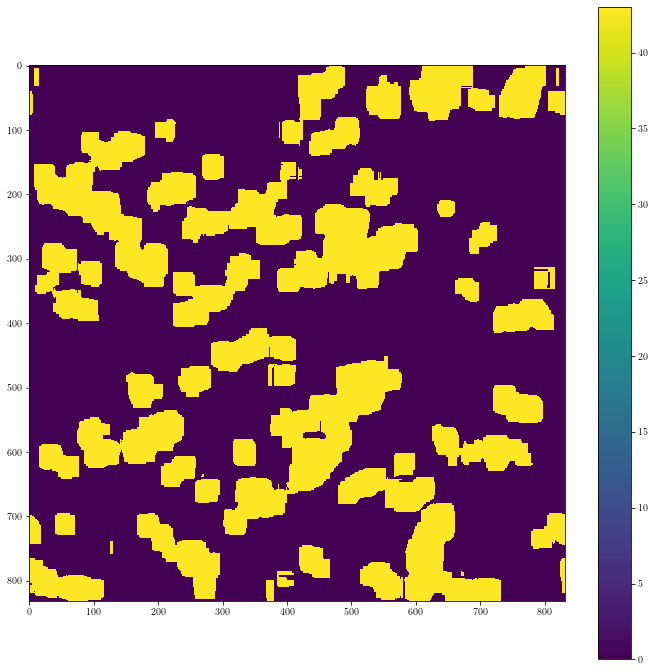

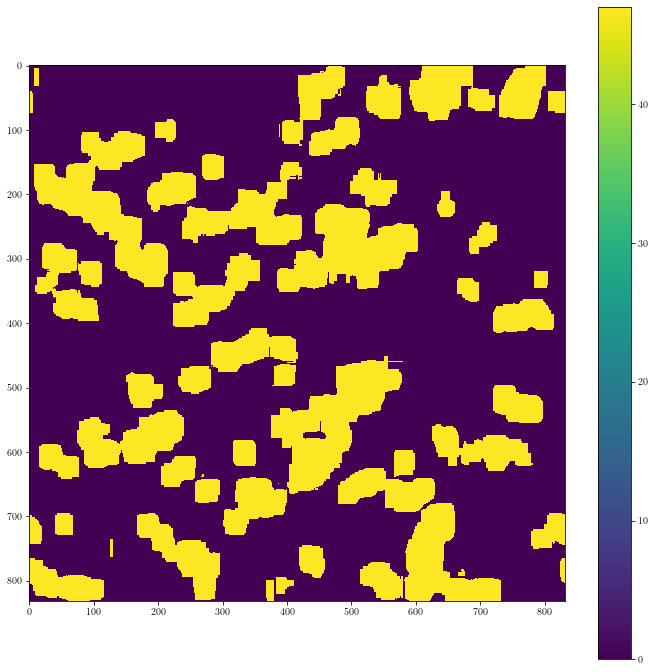

Error in callback <function flush_figures at 0x000002467EA56CA8> (for post_execute):


KeyboardInterrupt: 

In [67]:
factors = factor_prime_mask(group_orbit_covering, first_nprimes(len(group_orbit)))
for f in factors:
    _ = plt.figure(figsize=(12,12))
    _ = plt.imshow(f)
    _ = plt.colorbar()

Calculate how much each member contributes to the area covered.

In [63]:
area_covered = group_orbit_covering[group_orbit_covering!=0]

In [42]:
group_orbit_covering.size, area_covered.size

NameError: name 'group_orbit_covering' is not defined

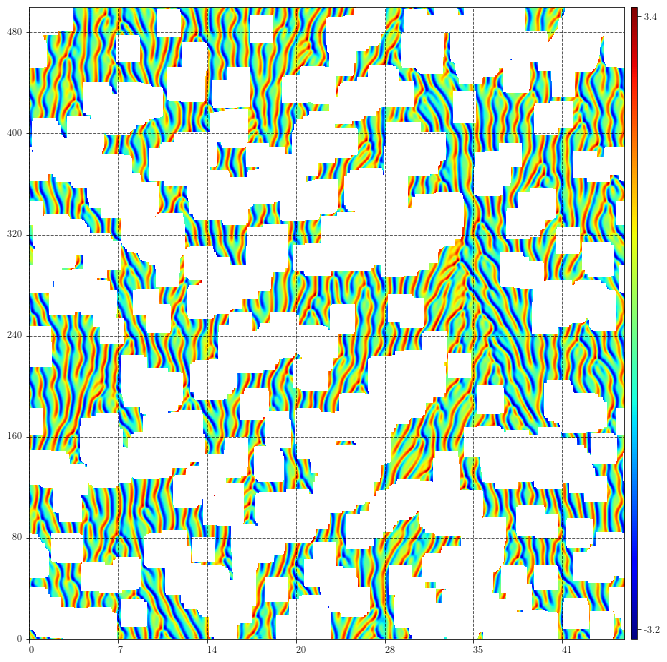

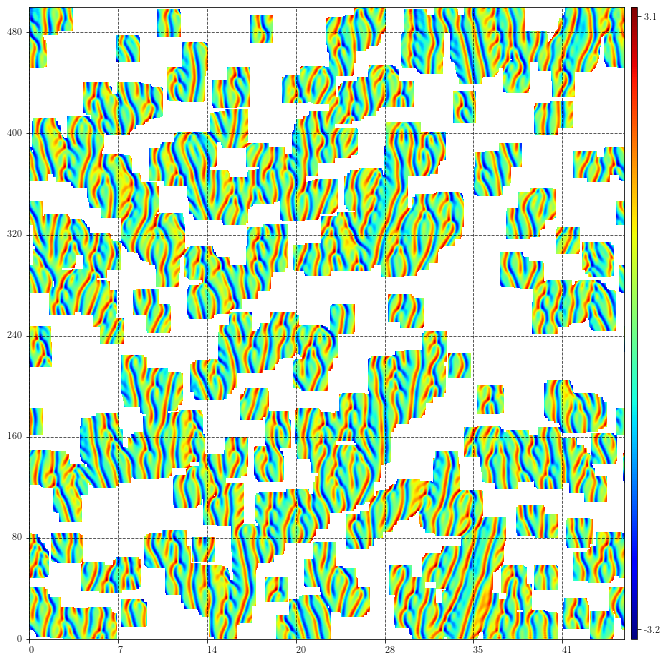

In [68]:
bool_mask = group_orbit_covering.copy()
bool_mask[bool_mask!=0]=1
base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()
base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

In [ ]:
# group_orbit_critical_persistence_values = tuple([covering_critical_persistence_values[0]]*len(group_orbit))

# t0pg=time.time_ns()/10**9
# group_orbit_covering_persistence = cover(base, group_orbit_critical_persistence_values, group_orbit,
#                             mask_type='prime',
#                             replacement=True,
#                             score_type=score_type,
#                              base_orbit_periodicity=(False, True),
#                            scoring_function=scoring_function,
#                            persistence_function=persistence_function,
#                             cache=cache,
#                             strides=(1,1),
#                             verbose=True
#                            )
# t1pg=time.time_ns()/10**9

## Overlap as a function of stride distance

Computing the distance metrics for every possible pivot position is incredibly expensive. Therefore, it is important
to determine how coarsely we can downsample the base orbits and still achieve the same accuracy with our coverings.
The idea being that the metric varies continuously. Could probably use some method of finding the local minima but this brute force method is simpler.

To test this, use a single orbit with no group orbit. Use a relatively lax tolerance and both distance metrics.

In [6]:
# dt, dx = base.t/base.n, base.x/base.m
# for window in covering:
#     newdisc = int(2*((window.t/dt)//2)), int(2*((window.x/dx)//2))
#     covering_processed.append(window.resize(newdisc).transform(to='field'))
# covering_processed = np.array(covering_processed)[[0, 1, 2, 3, 4, 5, 8, 9]]

# strict_critical_values = np.array(strict_critical_values)[[0, 1, 2, 3, 4, 5, 8, 9]]
# critical_values = np.array(critical_values)[[0, 1, 2, 3, 4, 5, 8, 9]]
# fundamental_critical_values = np.array(fundamental_critical_values)[[0, 1, 2, 3, 4, 5, 8, 9]]
# strict_fundamental_critical_values = np.array(strict_fundamental_critical_values)[[0, 1, 2, 3, 4, 5, 8, 9]]



In [ ]:
# # %debug
# t0=time.time_ns()
# covering_mask_prime = cover(base, critical_values, covering,
#                             mask_type='prime', 
#                             score_type = 'persistence',
#                             scoring_function=scoring_function,
#                             persistence_function=persistence_function,
#                             cache=cache,
#                             strides=(128, 128))
# t1=time.time_ns()

In [ ]:
# score_type='persistence'
# scoring_function = gudhi_distance_from_persistence
# persistence_function = orbit_persistence
# side = 128
# times = []
# for i in range(0, 7):
#     strides = (side//2**i, side//2**i)
#     print(strides)
#     times.append(time.time_ns()/10**9)
#     defect_scores, cache = scan(base, covering[1], score_type=score_type, strides=strides,
#                                 scoring_function=scoring_function, persistence_function=persistence_function)
#     times.append(time.time_ns()/10**9)
#     print(times[-1]-times[-2])

# bool_mask = defect_scores.copy()
# bool_mask[bool_mask>0.1] = 0
# bool_mask[bool_mask!=0]=1

# bool_mask = (defect_scores<0.5).astype(int)
# orbit_mask = scanning_mask(bool_mask, base, covering[1], strides)

# plt.figure(figsize=(12,12))
# plt.imshow(orbit_mask.astype(int))
# plt.colorbar()
# plt.show()

# plt.imshow(np.ma.masked_array(base.state, mask=orbit_mask, fill_value=np.nan))

# base.__class__(state=np.ma.masked_array(base.state, mask=orbit_mask, fill_value=np.nan),
#                              basis='field', parameters=base.parameters).plot(padding=False)

# base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(orbit_mask.astype(bool)), fill_value=np.nan),
#                              basis='field', parameters=base.parameters).plot(padding=False)

I'm explicitly writing the critical values here, however, they are included as metadata in the corresponding covering .h5 files. The "strict" values are the values corresponding to the 0.01%, that is, only expect to capture NM/10000 points. 

# Key criterion to determine


To do this, need to describe the three main modes of the cover function; determined by the returning mask type.

```mask_type=='prime'``` : Label every orbit in the provided collection with a prime number. For each orbit, find its individual cover, encode the detections by the (log)prime and add it to the total mask. In this manner overlaps are detected and can also be uniquely identified.

```mask_type=='count'``` : Compute the cover for each orbit in the collection, sum the total number of detections at each site.
This would be equivalent to determining the number of unique primes at each site and is really only included for convenience. Typically one would want to run 'prime' instead of count in every case, as it does the same routine and includes more information.

```mask_type=='family'``` **(Default)**: Orbits provided are treated as "equivalent" in the sense that the mask return is simply the union of all overlapping masks. Because of the nature of the overlapping this can dramatically reduce the number of metric computations, if the detection rate is high. If the detection rate is low, worst case scenario is bounded above by primes/count. Therefore, one should first run primes to identify approximate minimal sets which provide the best cover and then run this. Also, the prime number encoding that happens internally is *per orbit*; multiple runs with ```mask_type=='union'``` in conjunction with external encoding, encodes *per family* and is the prescribed manner for computing complete covers. 



In [9]:
t0=time.time_ns()
covering_mask_prime = cover(base, critical_values, covering_processed, mask_type='prime', score_type='pointwise')
t1=time.time_ns()

In [51]:

test_scores, test_cache = scan(base, covering[0].abs(), score_type=score_type,
                     scoring_function=scoring_function,
                     persistence_function=persistence_function,
                     base_orbit_periodicity=(False, True), verbose=True, strides=(8,8), cache=cache
                    )

Using cached persistence values for base orbit, slices of shape (32, 32)


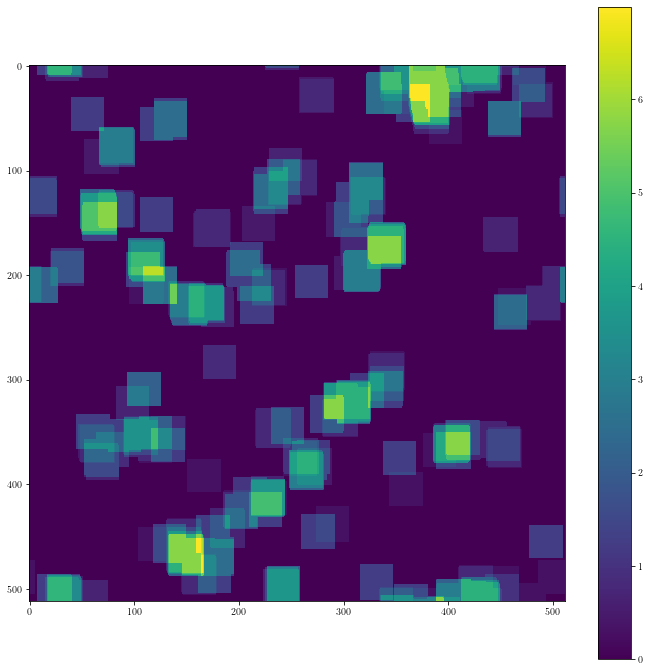

In [13]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(covering_mask_prime)
_ = plt.colorbar()

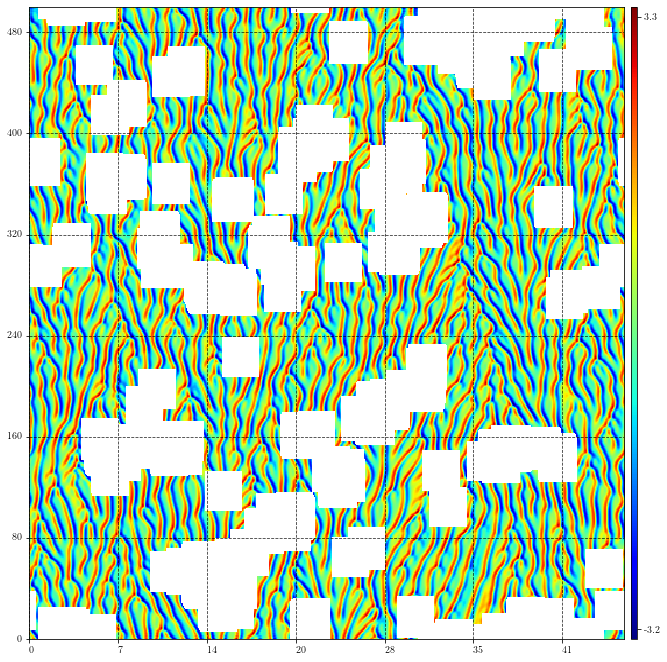

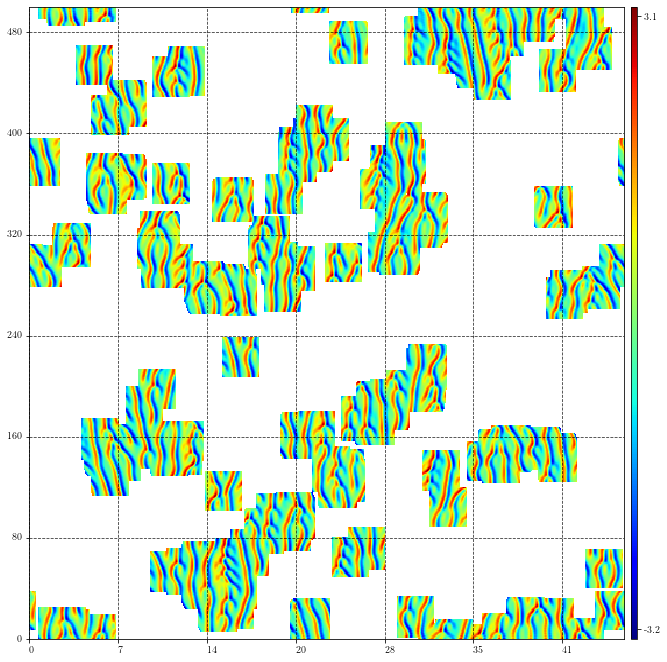

In [21]:
bool_mask = covering_mask_prime.copy()
bool_mask[bool_mask!=0]=1
base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()
base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

In [20]:
t0=time.time_ns()
covering_mask_persistence_prime = cover(base, critical_persistence_values, covering_processed, mask_type='prime',
                          score_type='persistence',
                          scoring_function=gudhi_distance_from_persistence,
                          persistence_function=orbit_persistence,
                          gudhi_kwargs={'min_persistence': 0.25})
t1=time.time_ns()

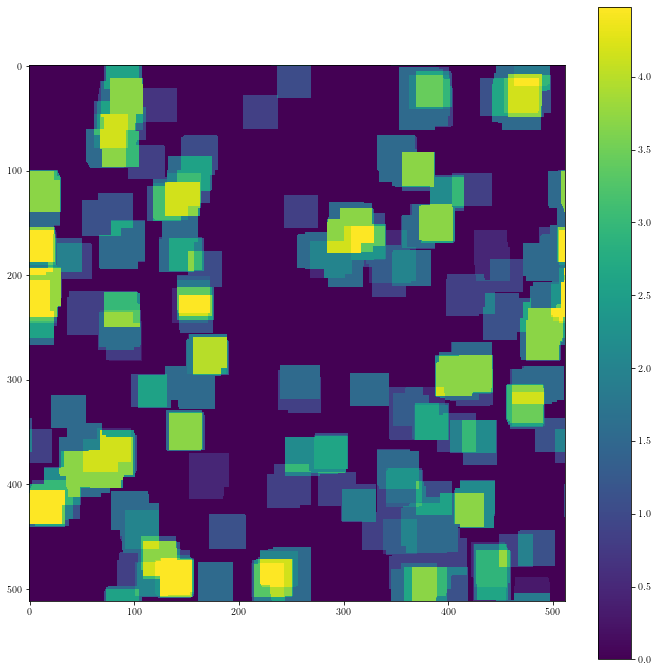

In [24]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(covering_mask_persistence_prime)
_ = plt.colorbar()

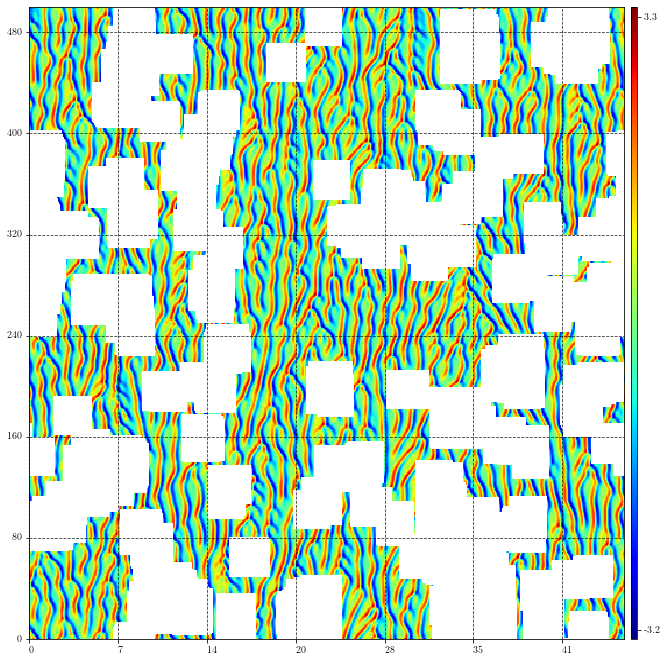

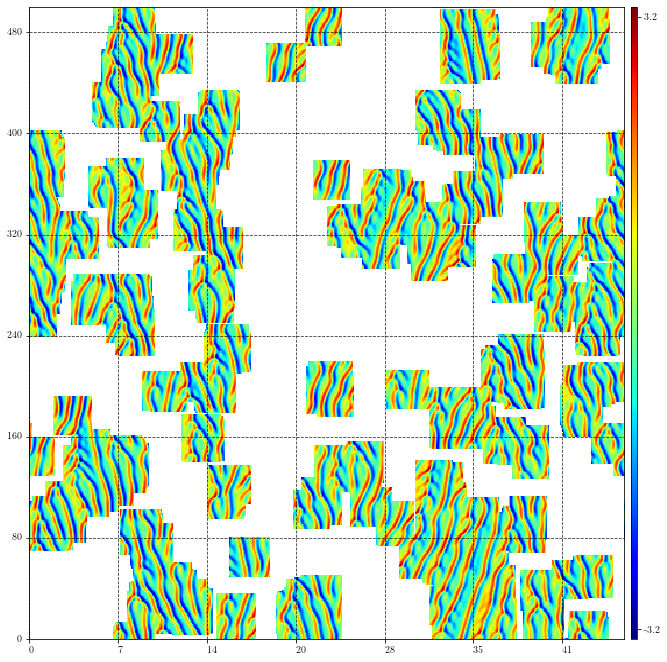

In [22]:
bool_mask = covering_mask_persistence_prime.copy()
bool_mask[bool_mask!=0]=1
base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()
base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

The issue in this case is that 

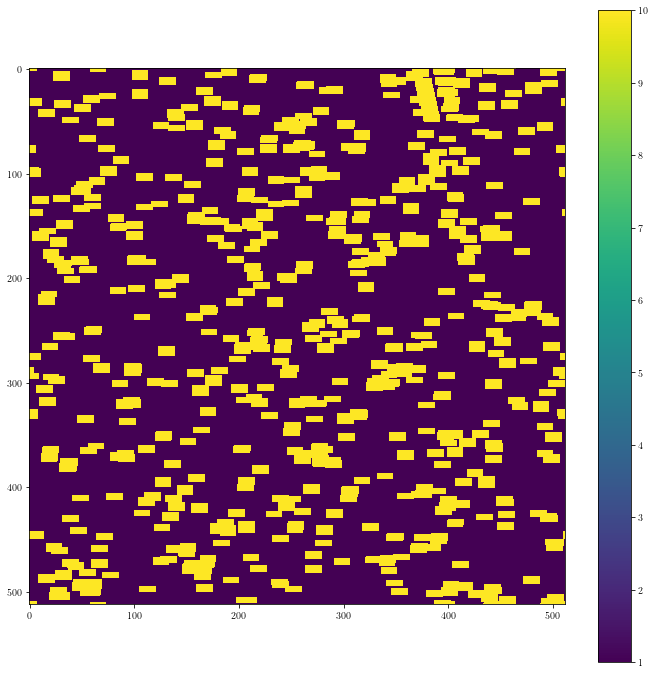

In [10]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(10**covering_mask)
_ = plt.colorbar()

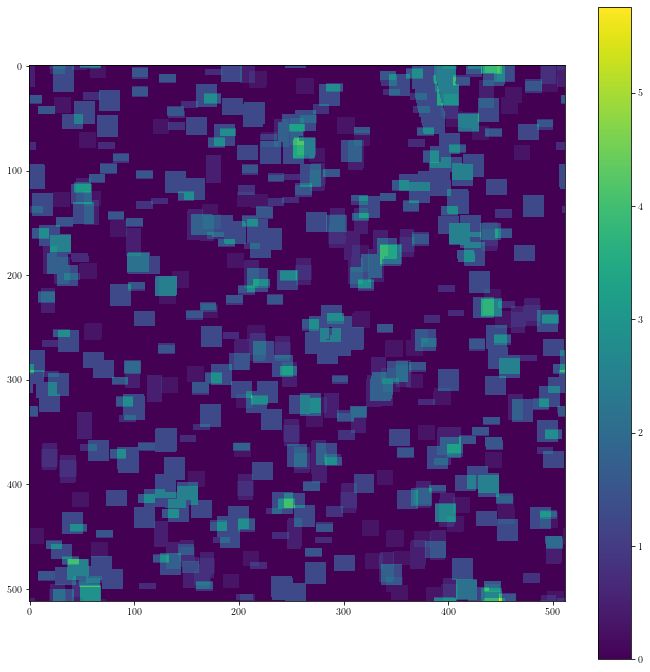

In [19]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(covering_mask_prime)
_ = plt.colorbar()

If you would like to look at how the mask factors into contributions by each orbit.

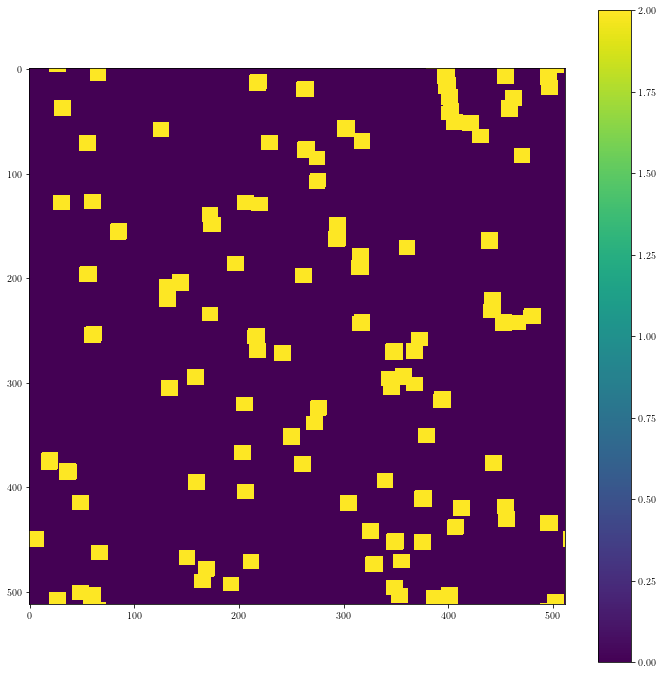

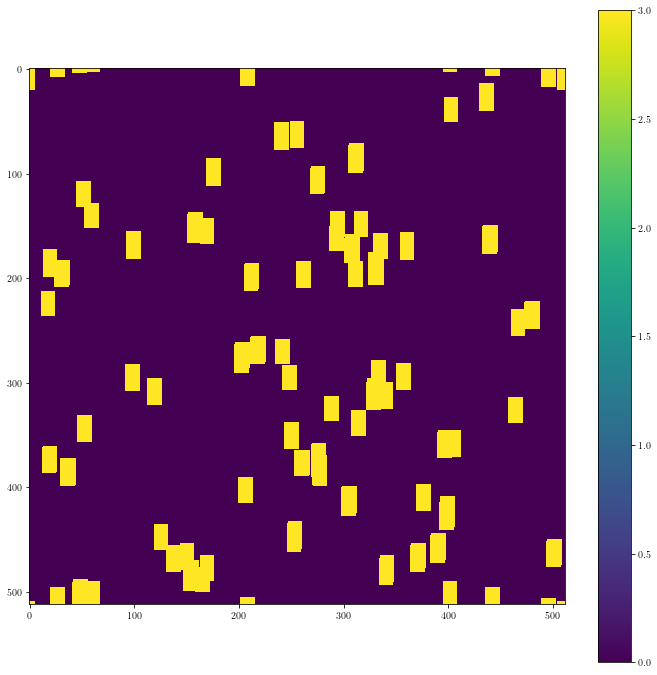

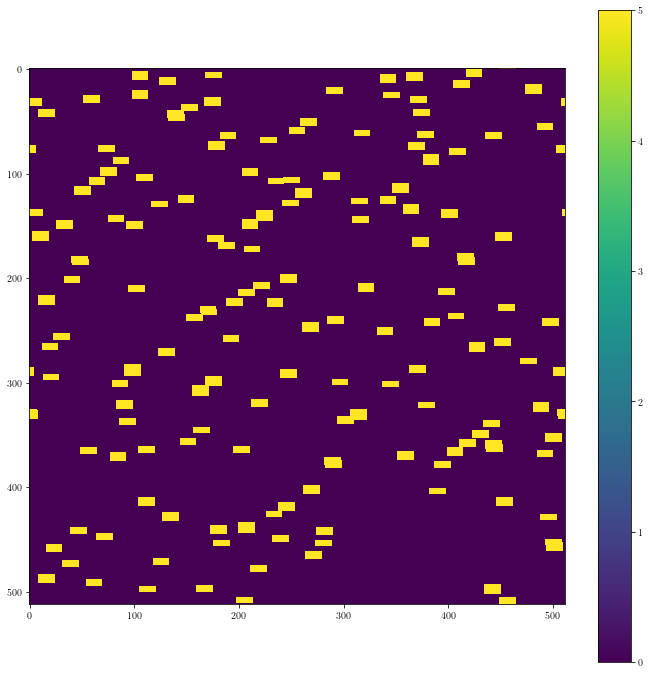

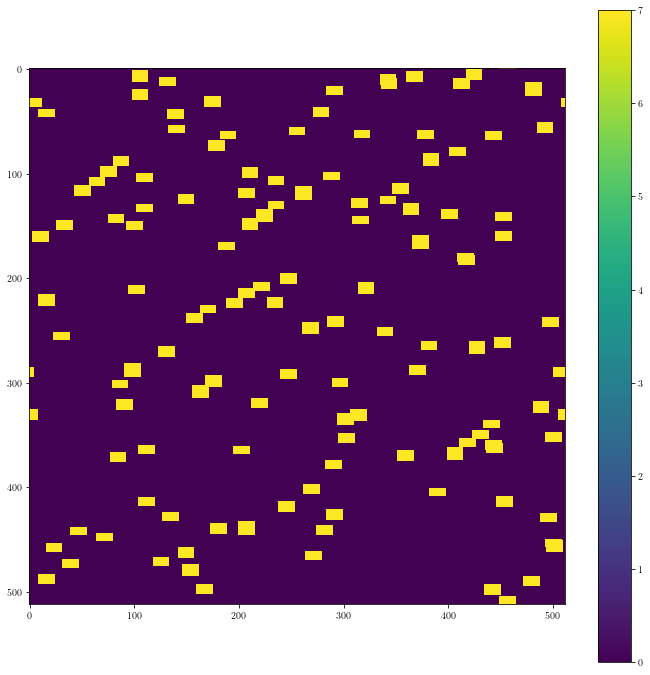

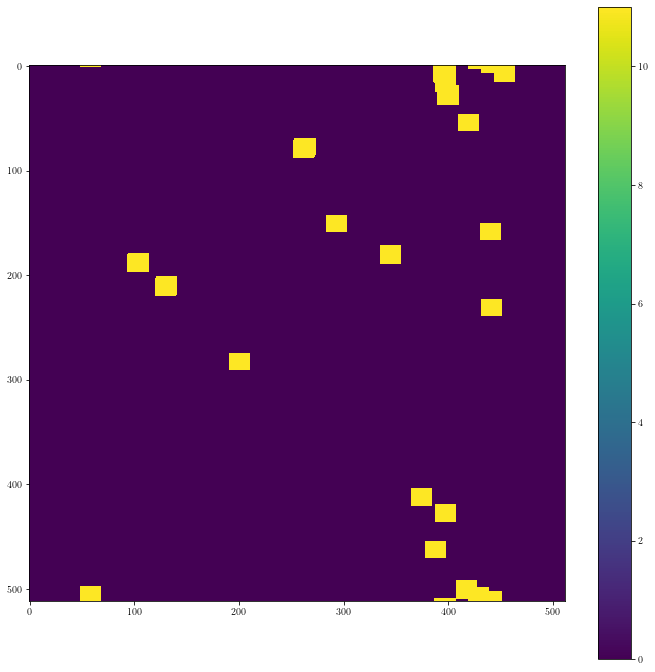

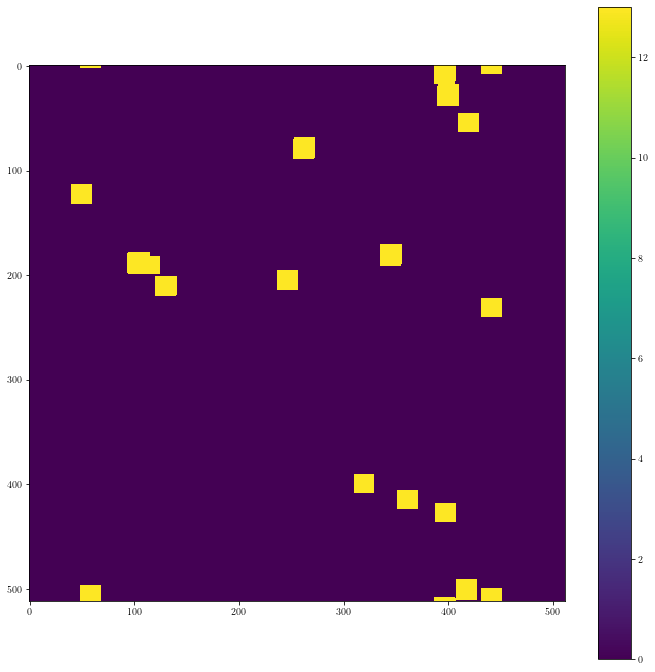

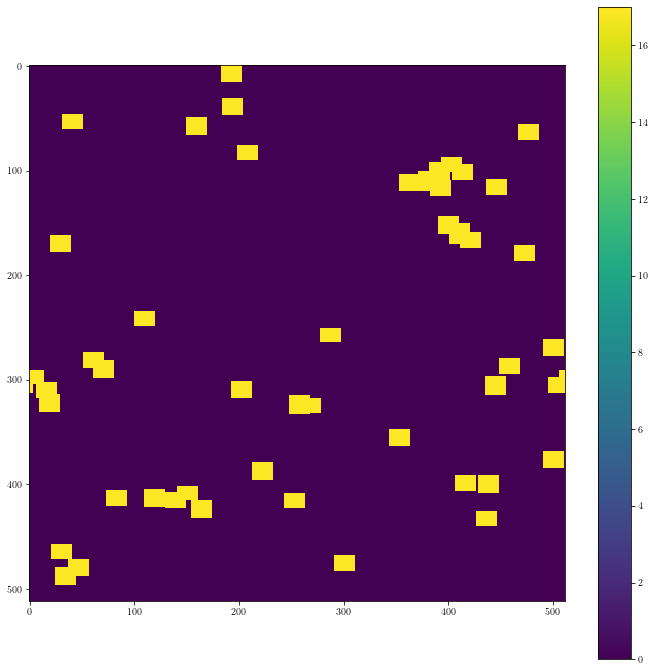

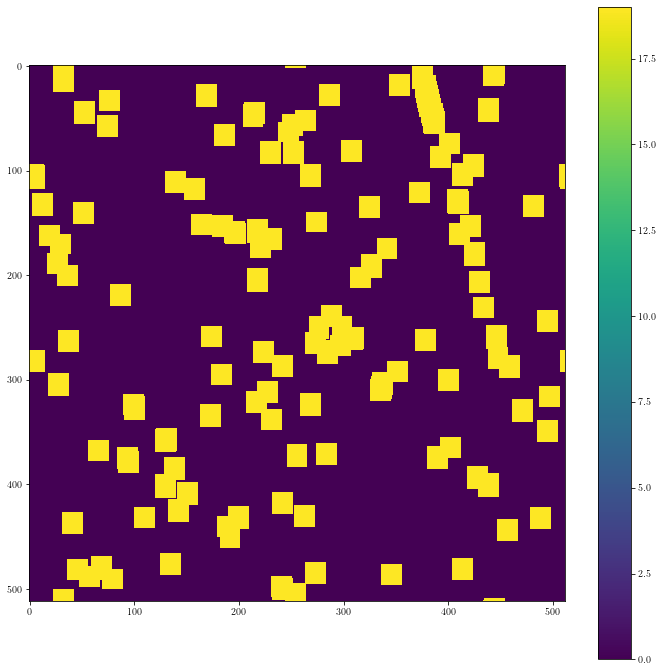

In [15]:
factors = factor_prime_mask(covering_mask_prime, first_nprimes(len(covering_processed)))
for f in factors:
    _ = plt.figure(figsize=(12,12))
    _ = plt.imshow(f)
    _ = plt.colorbar()

And when viewed in terms of the base orbit, both the interior and exterior produced by the mask.

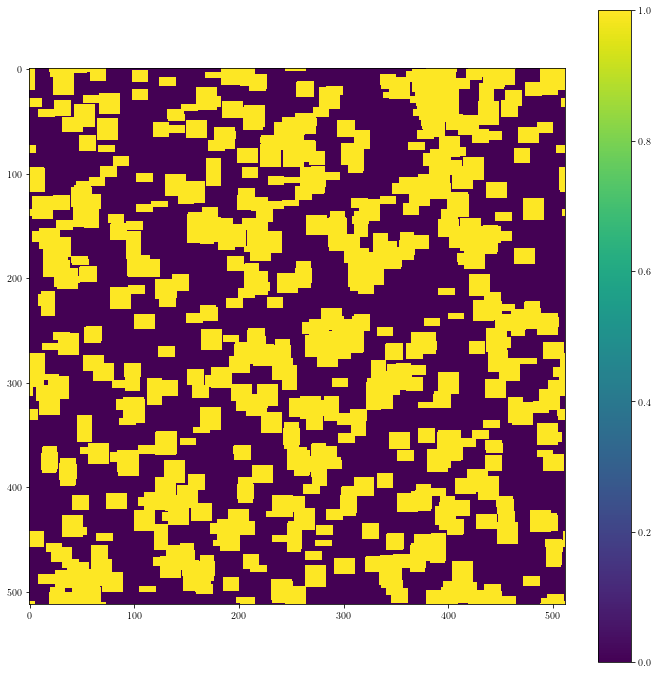

In [18]:
bool_mask = covering_mask_prime.copy()
bool_mask[bool_mask!=0]=1
# bool_mask = 
bool_mask = bool_mask.astype(int)
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(bool_mask)
_ = plt.colorbar()

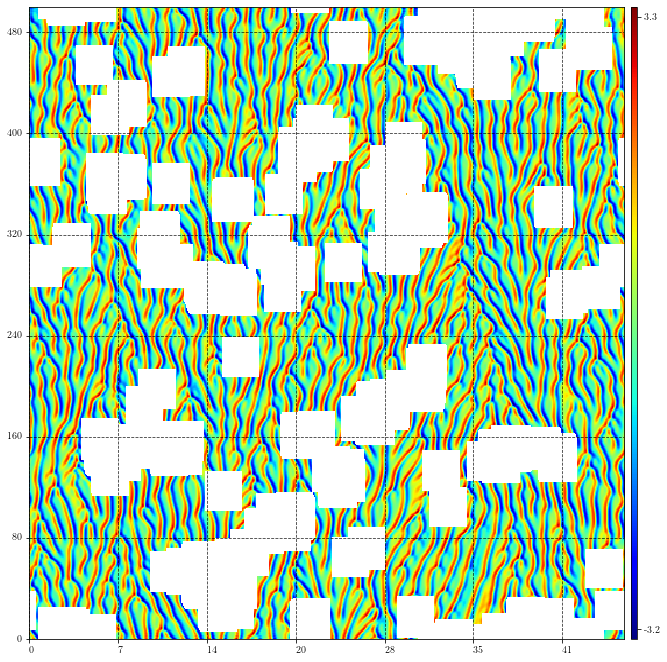

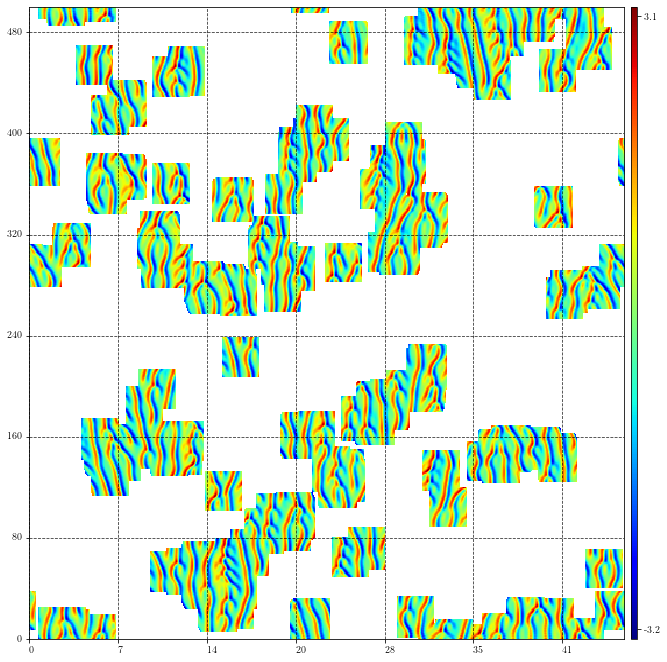

In [39]:
bool_mask = covering_mask_prime.copy()
bool_mask[bool_mask!=0]=1
base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()
base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

The results are not good. They can be improved by using the relative periodic orbits' "fundamental domains" which is to say, NOT the comoving frame. For this reason, the group orbit of every RelativeOrbitKS in the covering returns orbits in the fundamental domain or 'physical' frame. Because we are being exhaustive and using all group orbit members, the strictest values are used as thresholds. For the sake of chopping the computation into pieces, we shall call the cover function once for each family; this will also allow us to see how intense the overlap is per family, i.e. if the group orbits can be down sampled.
This might run into overflow issues however, as we are using the first 500 or so primes.

In [38]:
# Can actually pass generator itself, if we knew a priori how big each group orbit it. 
covering_group_orbits = []
cvals = []
for i, window in enumerate(covering_processed):
    window_group_orbit = []
    window_cvals = []
    # Only trying to capture spatial drift velocity with fundamental domains. 
    if window.__class__ not in [AntisymmetricOrbitKS, EquilibriumOrbitKS]:
        for g_window in window.group_orbit(fundamental_domain=True):
            window_group_orbit.append(g_window)
            window_cvals.append(strict_fd_cval[i])
    else:
        for g_window in window.group_orbit():
            window_group_orbit.append(g_window)
            window_cvals.append(strict_critical_values[i])
    cvals.append(window_cvals)
    covering_group_orbits.append(window_group_orbit)

This searches over the group orbit members of each of the 8 original orbits, over a single base orbit. Statistics on
the proportional areas covered are the next part.

In [25]:
family_masks = read_h5('../small_cover_family_masks.h5')

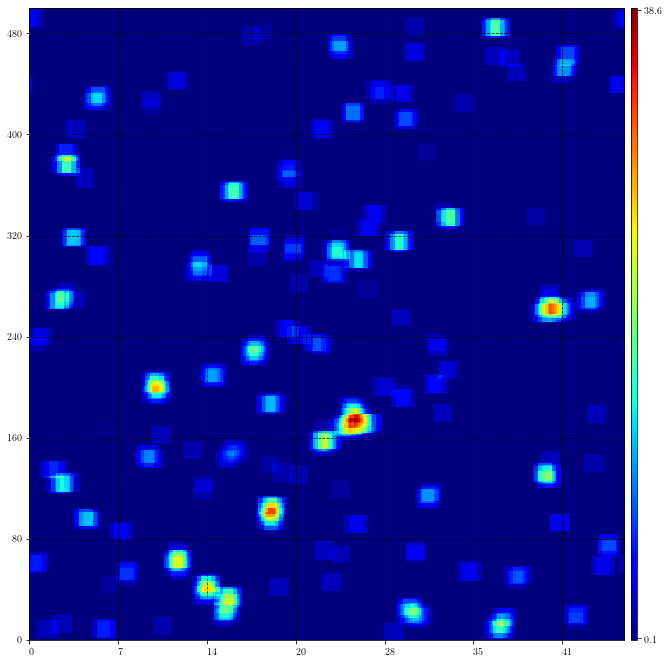

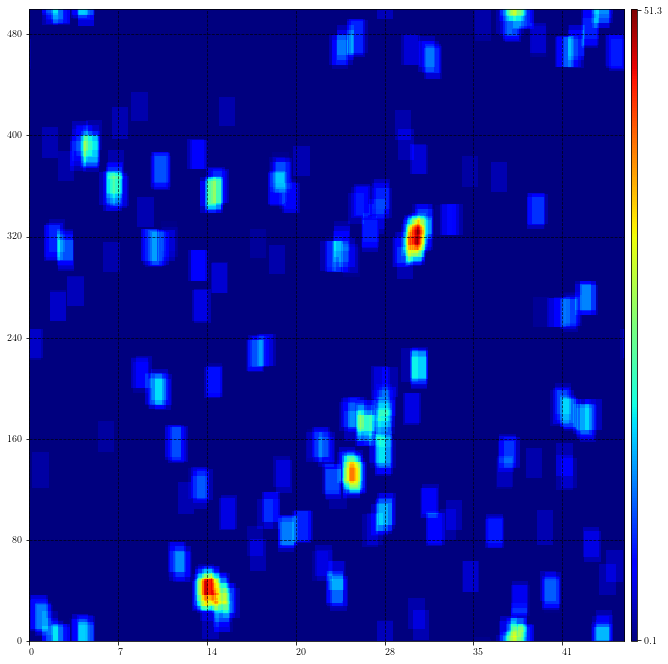

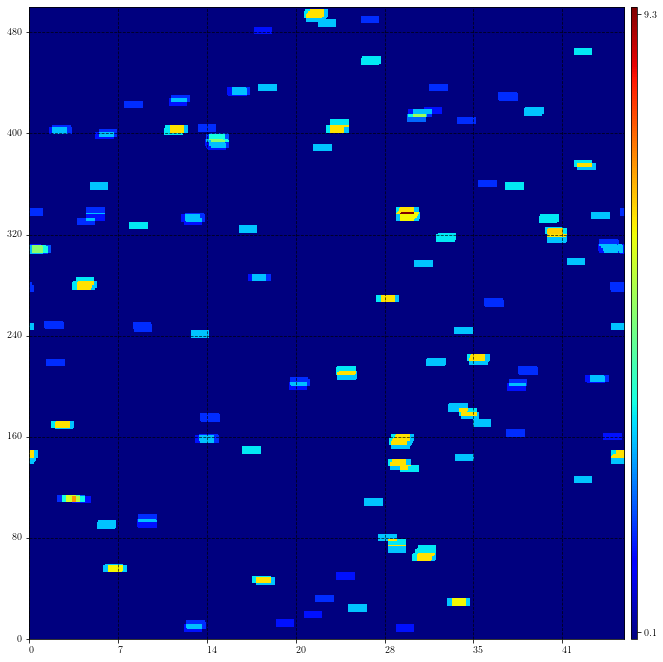

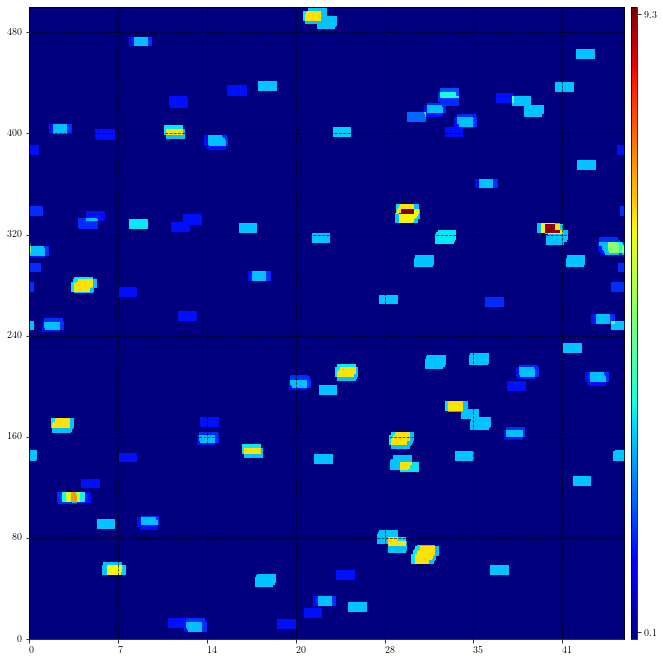

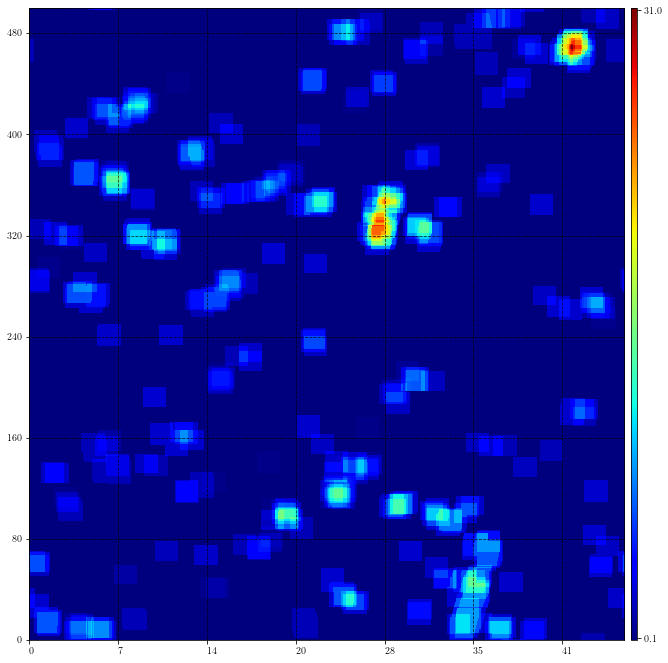

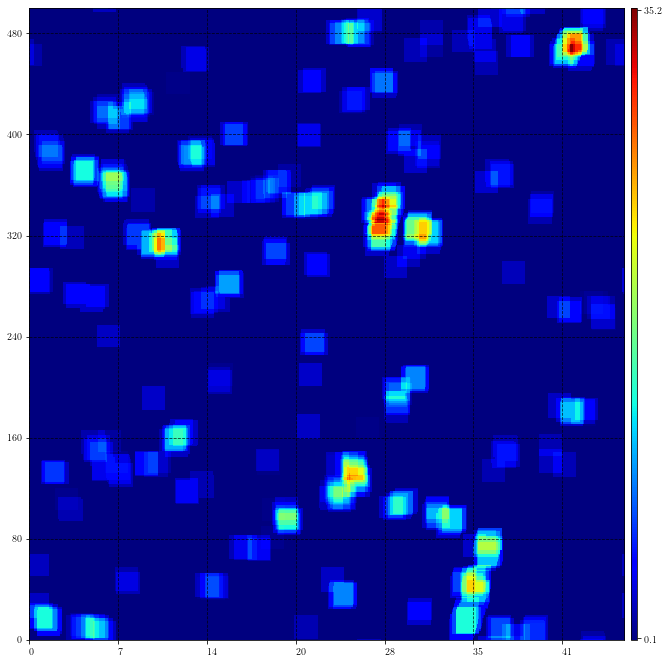

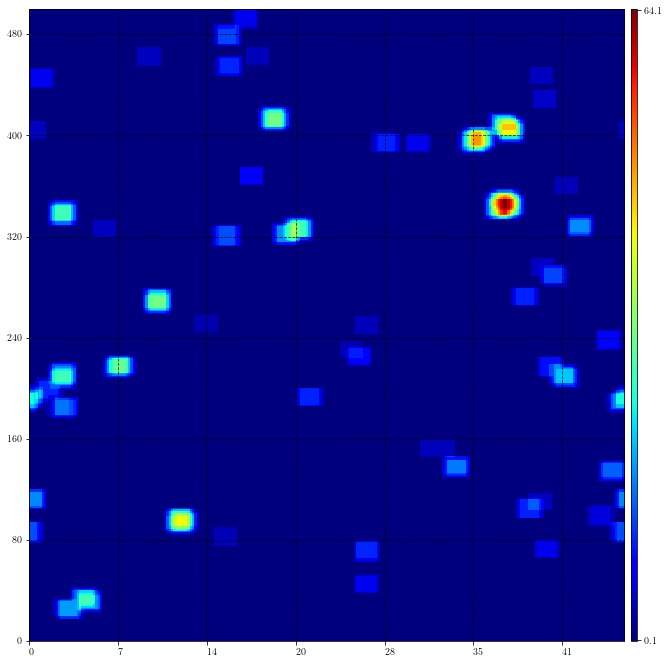

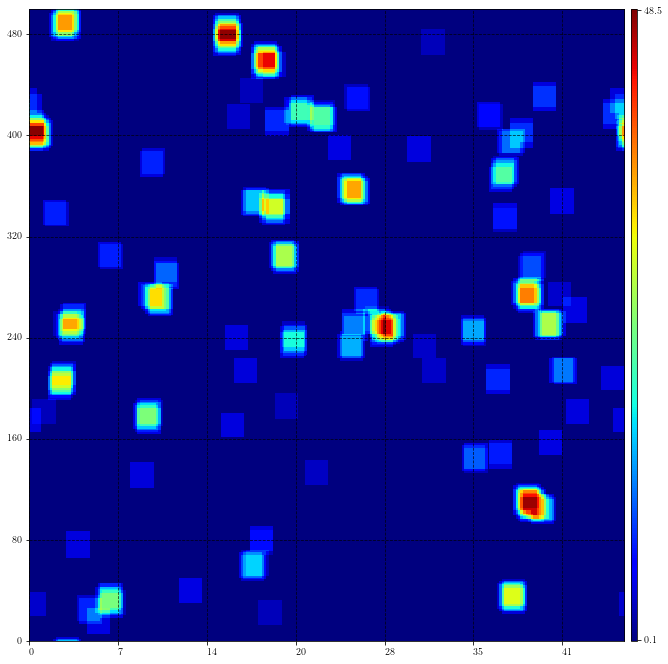

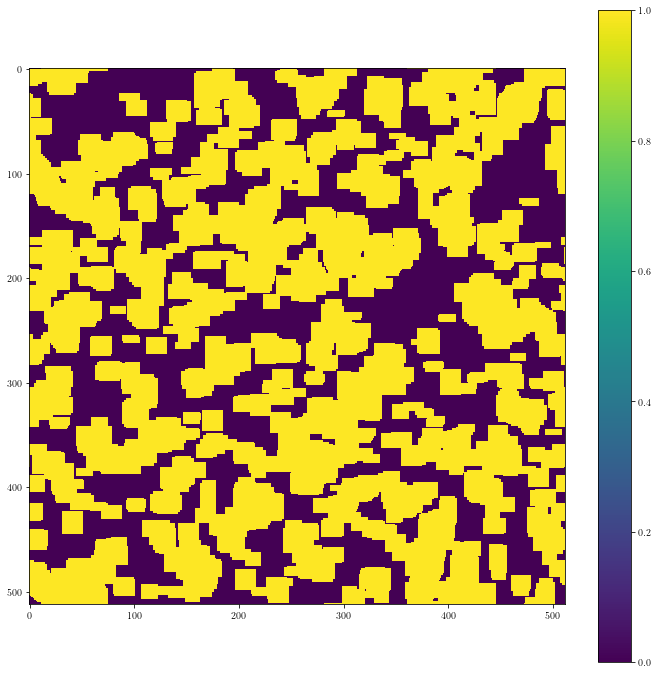

In [32]:
bool_mask = np.zeros([512, 512], dtype=bool)
for x in family_masks:
    x.plot()
    tmp = x.state.copy()
    tmp[tmp!=0]=1
    bool_mask = np.logical_or(bool_mask, tmp.astype(bool))
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(bool_mask.astype(int))
_ = plt.colorbar()

In [37]:
tmp = covering_mask_persistence_prime.copy()
tmp[tmp!=0]=1
tmp = tmp.astype(bool)
bool_mask = np.logical_or(bool_mask,tmp)

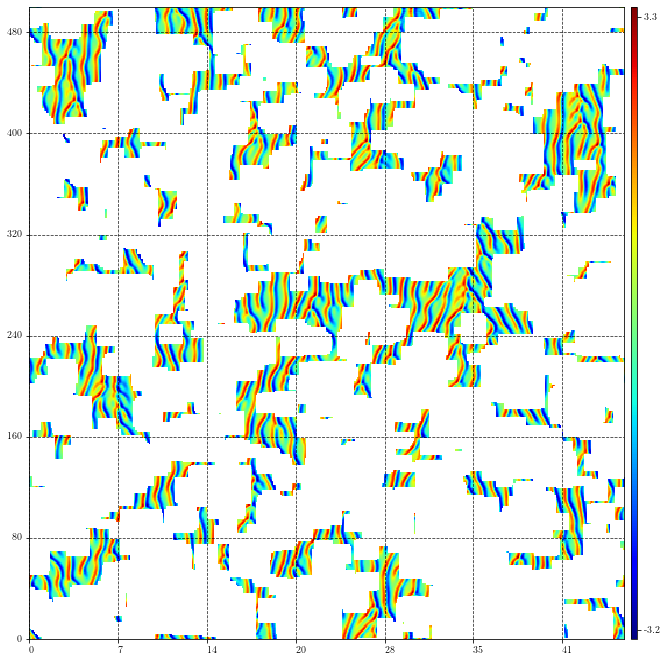

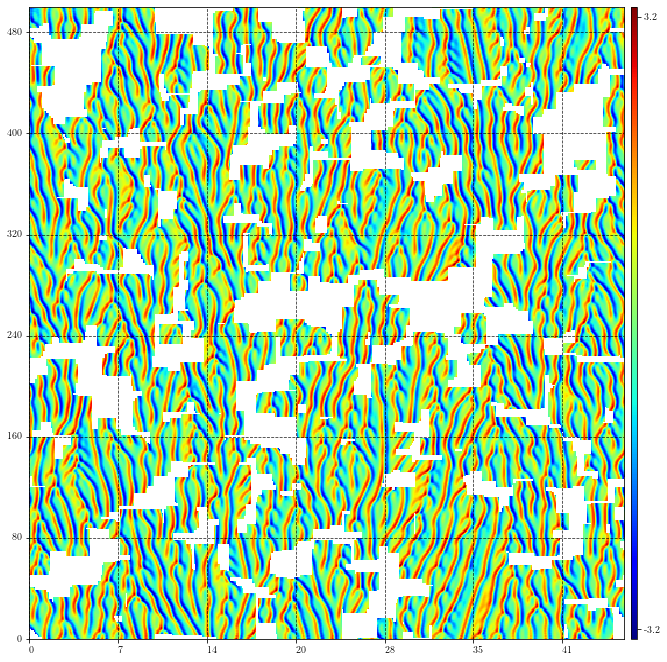

In [38]:
base.__class__(state=np.ma.masked_array(base.state, mask=bool_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()
base.__class__(state=np.ma.masked_array(base.state, mask=np.invert(bool_mask.astype(bool)), fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

In [40]:
family_masks = []
times = []
times.append(time.time_ns()/10**9)
for cv, windows in zip(cvals, covering_group_orbits):
    family_masks.append(cover(base, cv, windows, mask_type='prime'))
    print('#', end='')
    times.append(time.time_ns()/10**9)

#

KeyboardInterrupt: 

Can leverage orbithunter class objects to save these masks in an h5 file.

In [82]:
# for fm in family_masks:
#     OrbitKS(state=fm, parameters=base.parameters, basis='field').to_h5(filename='small_cover_family_masks.h5')

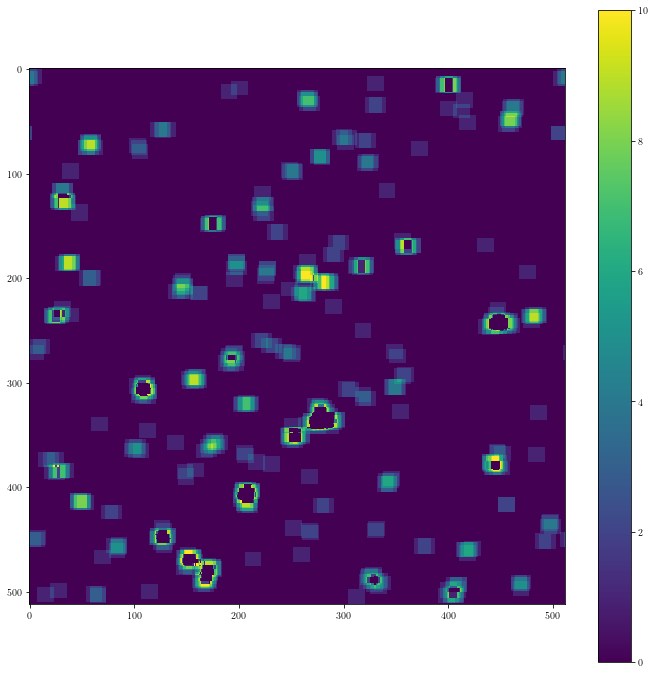

In [138]:
# for f in family_masks:
f = family_masks[0]
primes = first_nprimes(len(f))
factors = factor_prime_mask(f, primes)
count_encoding = np.zeros(family_masks[0].shape)
for fac in factors:
    fmp = fac.copy()
    fmp[fmp!=0]=1
    count_encoding += fmp
    
count_encoding[count_encoding>10]=0
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(count_encoding)
_ = plt.colorbar()

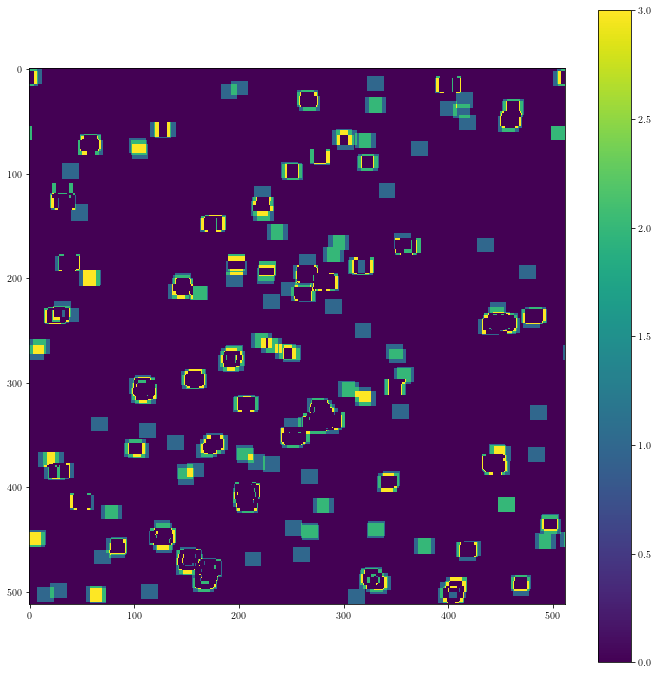

In [140]:
count_encoding[count_encoding>3]=0
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(count_encoding)
_ = plt.colorbar()

In [ ]:
primes = first_nprimes(len(family_masks))
new_primes_encoding = np.zeros(family_masks[0].shape)
for p, f in zip(primes, family_masks):
    # reencode to see overlap between families.
    fmp = f.copy()
    fmp[fmp!=0]=1
#     fmp[fmp==0]=0
    # simply want a count, do not need prime factoring
    new_primes_encoding += fmp

_ = plt.figure(figsize=(12,12))
_ = plt.imshow(new_primes_encoding)
_ = plt.colorbar()

In [100]:
for f in family_masks:
    primes = first_nprimes(len(f))
    new_primes_encoding = np.zeros(f[0].shape)
    factors = factor_prime_mask(mask, primes)
    prime_f = f.copy()
    boolfm[boolfm!=0]=1
    _ = plt.figure(figsize=(12,12))
    _ = plt.imshow(boolfm)
    _ = plt.colorbar()

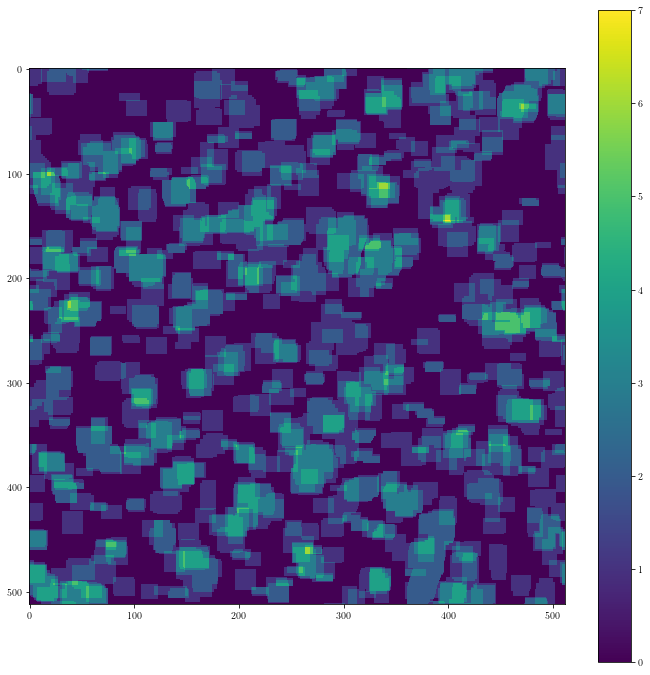

In [123]:
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(new_primes_encoding)
_ = plt.colorbar()

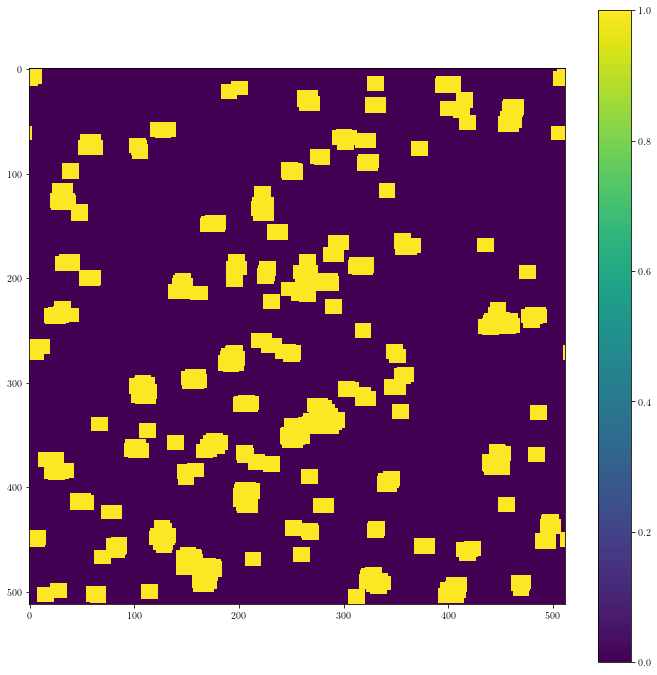

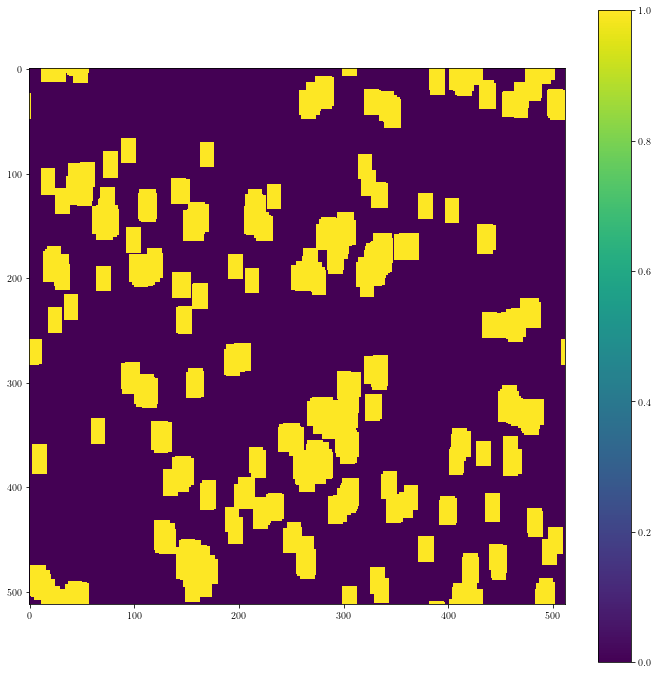

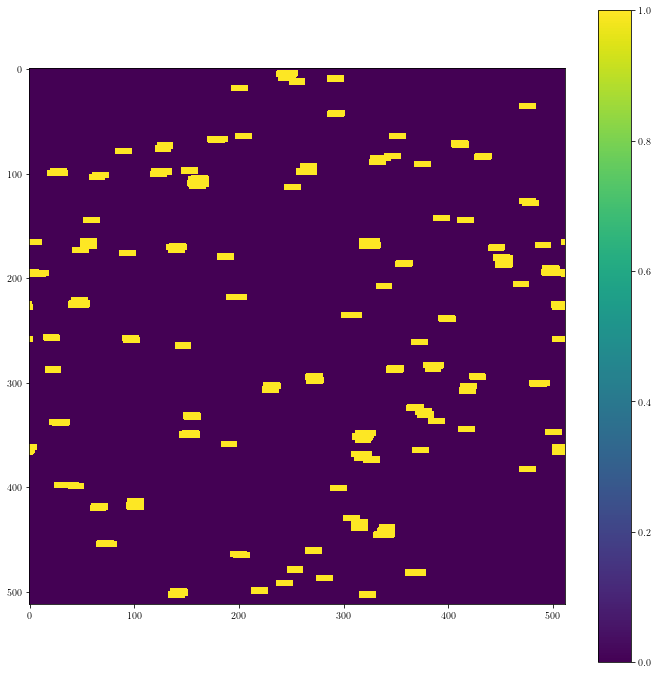

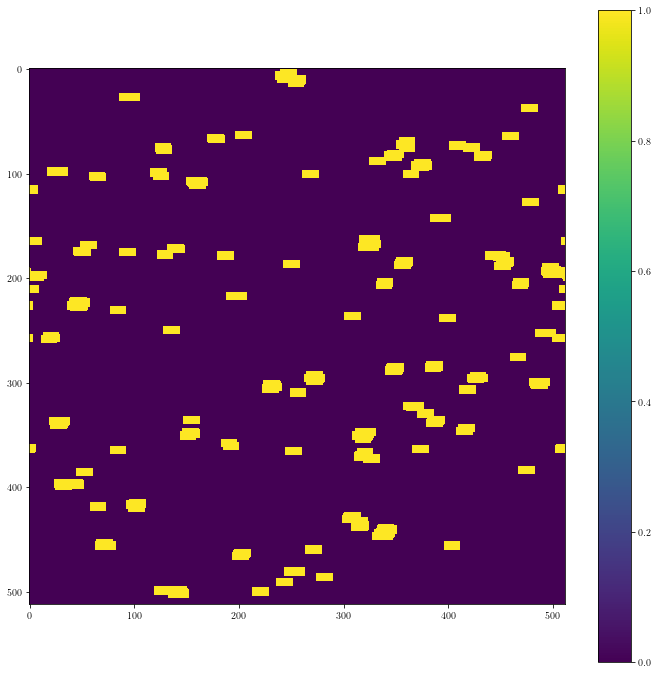

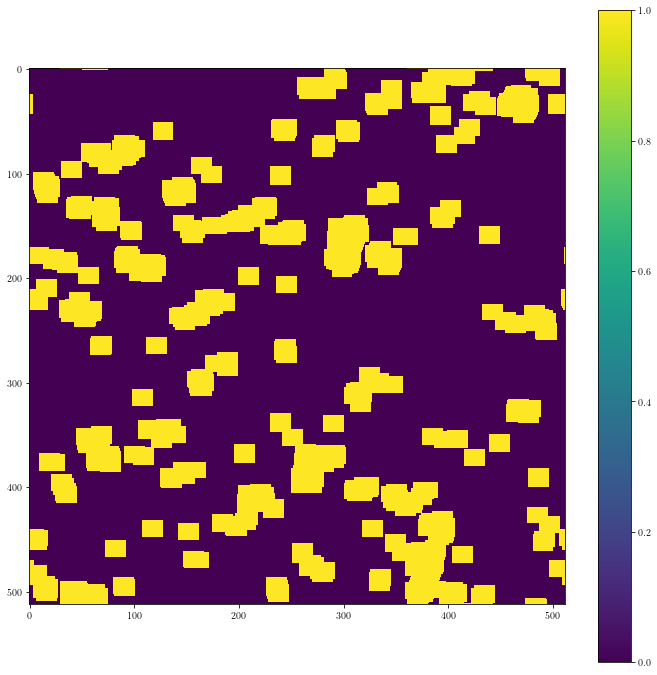

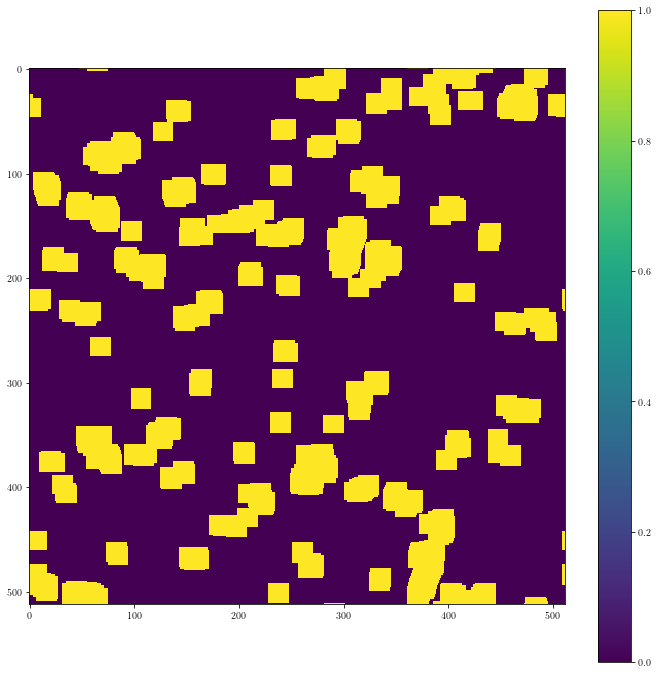

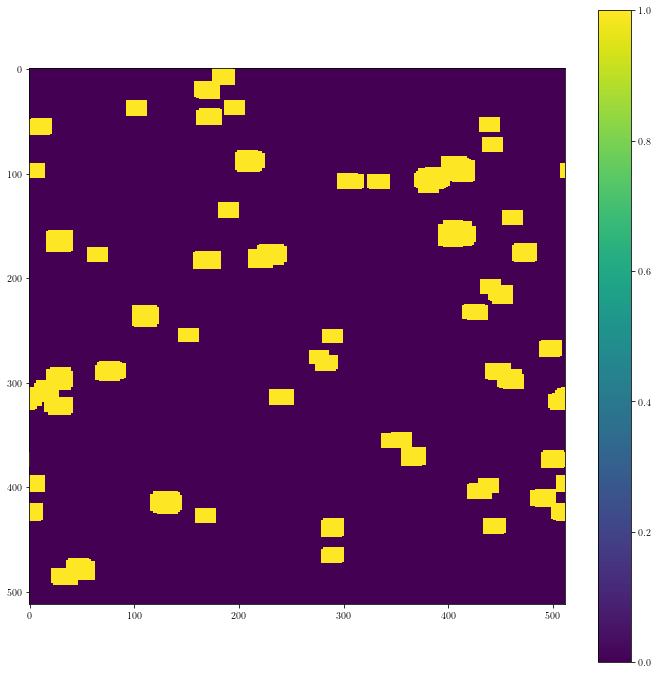

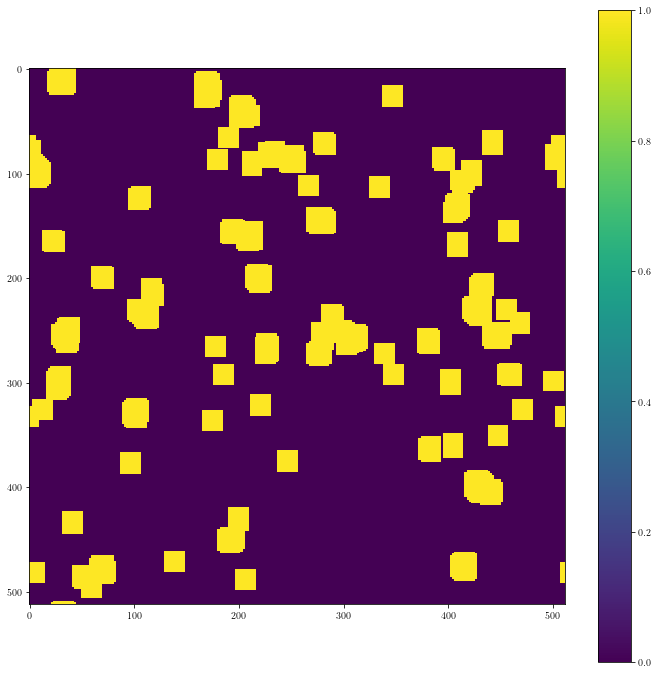

In [97]:
for f in family_masks:
    boolfm = f.copy()
    boolfm[boolfm!=0]=1
    _ = plt.figure(figsize=(12,12))
    _ = plt.imshow(boolfm)
    _ = plt.colorbar()

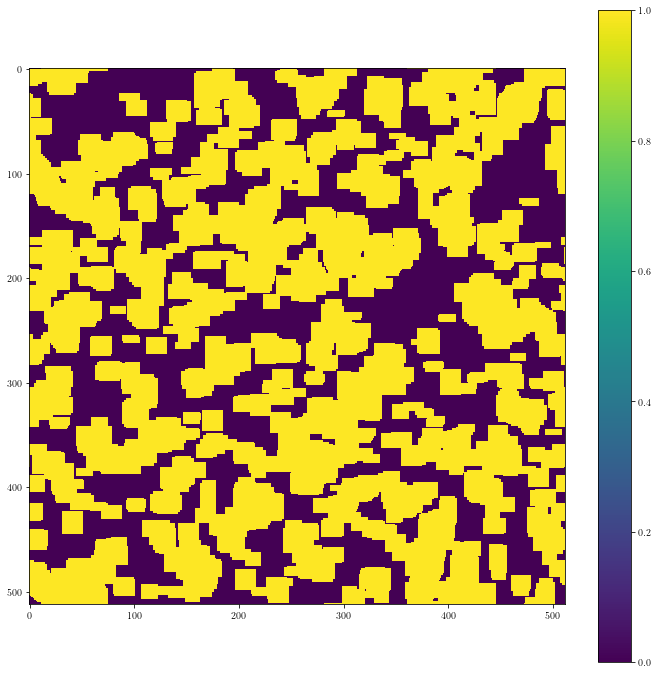

In [105]:
bool_union_mask = family_masks[0].copy().astype(bool)
primes = first_nprimes(len(family_masks))
for p, f in zip(primes, family_masks):
    boolfm = f.copy()
    boolfm[boolfm!=0]=1
    bool_union_mask = np.logical_or(bool_union_mask, boolfm.astype(bool))
    
_ = plt.figure(figsize=(12,12))
_ = plt.imshow(bool_union_mask.astype(int))
_ = plt.colorbar()

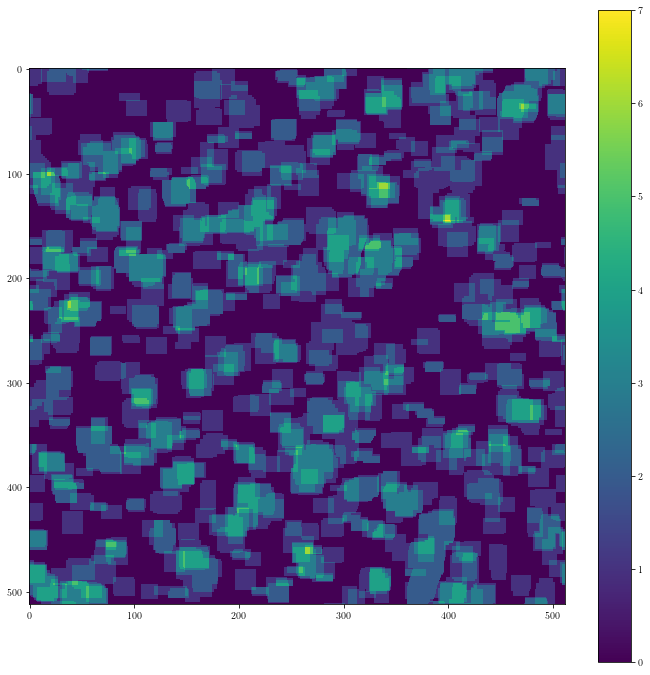

In [120]:
primes = first_nprimes(len(family_masks))
new_primes_encoding = np.zeros(family_masks[0].shape)
for p, f in zip(primes, family_masks):
    # reencode to see overlap between families.
    fmp = f.copy()
    fmp[fmp!=0]=1
    # fmp[fmp==0]=0
    # simply want a count, do not need prime factoring
    new_primes_encoding += fmp

_ = plt.figure(figsize=(12,12))
_ = plt.imshow(new_primes_encoding)
_ = plt.colorbar()

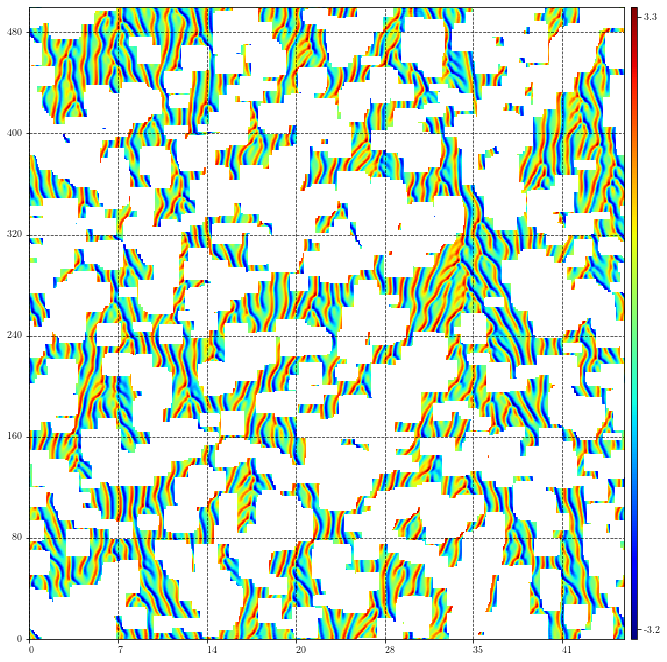

In [116]:
base.__class__(state=np.ma.masked_array(base.state, mask=bool_union_mask, fill_value=np.nan),
                             basis='field', parameters=base.parameters).plot()

In [52]:
family_masks = []
for cv, windows in zip(cvals, covering_group_orbits):
    family_masks.append(cover(base, cv, windows, mask_type='prime'))
    print('#', end='')

########

Can leverage orbithunter class objects to save these masks in an h5 file.

In [82]:
# for fm in family_masks:
#     OrbitKS(state=fm, parameters=base.parameters, basis='field').to_h5(filename='small_cover_family_masks.h5')

The previous run used the strict thresholds; before becoming less strict, let us simply be exhaustive with our covering. what if they are laxened?

In [ ]:
# covering_group_orbits = []
# cvals = []
# for i, window in enumerate(covering_processed):
#     window_group_orbit = []
#     window_cvals = []
#     # Only trying to capture spatial drift velocity with fundamental domains. 
#     if window.__class__ not in [AntisymmetricOrbitKS, EquilibriumOrbitKS]:
#         for g_window in window.group_orbit(rolls=(4, 4), fundamental_domain=True):
#             window_group_orbit.append(g_window)
#             window_cvals.append(fd_cval[i])
#     else:
#         for g_window in window.group_orbit(rolls=(4, 4)):
#             window_group_orbit.append(g_window)
#             window_cvals.append(critical_values[i])
#     cvals.append(window_cvals)
#     covering_group_orbits.append(window_group_orbit)

In [ ]:
# lax_family_masks = []
# for cv, windows in zip(cvals, covering_group_orbits):
#     lax_family_masks.append(cover(base, cv, windows, mask_type='prime'))
#     print('#', end='')